# Project Topic - High Level Exercise Goal
This project is a Credit Card Fraud experiment leveraging credit card transaction data to train a classification model that will predict if unseen transaction data will be a fraudulent transacation or not.  

Although different types of electronic payment methods have evolved over time, credit card payment method still takes on a significant portion of all the payment volume.  Because of this, credit card fraud detection is still very much relevant to payment processor and potential (predicted) fraudulent charge could be stopped or confirmed by the card holder (transaction held until card holder confirms purchase).  This is a very common scenario that a lot of us may have experienced and that's also the reason why I choose this data source for my learning journey.

The objective of this ML exercise is to:  
1. Train a surpervised learning classification model (learning from labelled data)
2. Determine if future "unseen" credit card transaction is "potentially" fradulent
3.  Exercise "muscle memory" of common Machine Learning (ML) best practice:
*   Data wangling & cleaning
*   Exploratory data analysis (EDA)
*   Feature treatments
*   Model performance and selection
*   Presentation of discovery




# Data - Data Sources
Credit Card Fraud data source hosted in Kaggle contributed by Dhanush NaraYanan R.

https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data

This data source is licensed under "CC0: Publich Domain".

Data source is a single ~76Mb data file and containes 1MM samples of 8 features:
1. distance_from_home - numberic - Distance from credit card registration address
2. distance_from_last_transaction - numeric - Distance of the current transation from the previous transaction on the same credit card
3. ratio_to_median_purchase_price - numeric - Ratio of current charge to median purchase price
4. repeat_retailer - categorical - current charge made to frequent store / retailer
5. used_chip - categorical - IC chip used to authorize charge
6. used_pin_number - categorical - PIN used to authorize charge
7. online_order - categorical - current charge made for online purchase
8. fraud - categorical - prediction of whether charge may be fraudulent - this is the target variable that we would like to predict

At a first glance, the initial intuition is feature #1, #2, #5, #6 are "card present" type of purchases, ie, card holder makes purchase in person.

# Preparation / Initialization

1. To make this notebook more self-contained (and tried to avoid storing my Kaggle API key for download in the notebook -- a bad practice), I copied the data to my Google drive.

2. For similar reason, I will also initialize values for the reproducibility of this notebook

In [1]:
random_seed = 202406

# Acquire Additional Packages
Acquire additional Python packages that may not be readily available in the Jupyter notebook environment (in this case Google Colab)

Packages list:


*   gdown - Used to download credit card transacation data stored in Google drive (card-transdata.csv)



In [2]:
# Acquire prerequisite packages
!pip install gdown
!pip install imbalanced-learn
!pip install --upgrade seaborn
!pip install pycaret --user

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

from imblearn.over_sampling import SMOTENC

from pycaret.classification import *

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings

import gdown

warnings.filterwarnings('ignore')

In [5]:
gdown.download('https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo', './final/card_transdata.csv')

Downloading...
From: https://drive.google.com/uc?id=1cq3EBN238kBUW4R0u4rDYlyv9HqvqsDo
To: C:\Users\petelam\Downloads\final\card_transdata.csv
100%|██████████| 76.3M/76.3M [00:04<00:00, 15.8MB/s]


'./final/card_transdata.csv'

Load raw data file into a dataframe

In [6]:
df_credit_card_fraud_org = pd.read_csv('C:\\Users\\petelam\\Downloads\\final\\card_transdata.csv', sep=',', header=0, index_col=False, engine='python')

# Data - Basic Data Understanding

*   From DF.info() & describe(), I acquire some basic understanding of the data:
  *   the data set shape is a 100k x 8 tabular data, all features are of numeric type and there is **no missing data** based on the reported number of occurence of all the attributes including the fraud label
  *   all of the features are already numeric, even the categorical features like: a) used_chip; b) used_pin_number; c) online_order; d) repeat_retailer and ***they are all of binary type of categorical feature, ie, True / False; therefore, there is NO need to further apply feature encoding techniques, like one-hot encoder, to encode them***

Use df.info() to learn:
1. Shape of dataframe
2. Data type of each feature & label
3. Any missing data data

Use df.drop_duplicates() to confirm no duplicate rows.

In [7]:
df_credit_card_fraud_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Use df.describe() to learn unusual charasteristics hidden in the data:
1. Any anonmalies / outliers
2. Imbalance data set


In [8]:
df_credit_card_fraud_org.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.9, 0.93, 0.95, 0.99])

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
90%,60.268980,10.008053,4.080939,1.000000,1.000000,1.000000,1.000000,0.000000
93%,78.908923,14.146703,5.050214,1.000000,1.000000,1.000000,1.000000,1.000000
95%,99.708638,19.170549,6.071425,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Confirm if there are duplicate rows

count_before = df_credit_card_fraud_org.shape[0]
count_after = df_credit_card_fraud_org.drop_duplicates().shape[0]
print(f"Dataset length before:{count_before}, after:{count_after}")
print("No duplicate rows found...")

Dataset length before:1000000, after:1000000
No duplicate rows found...


For quick data value density:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

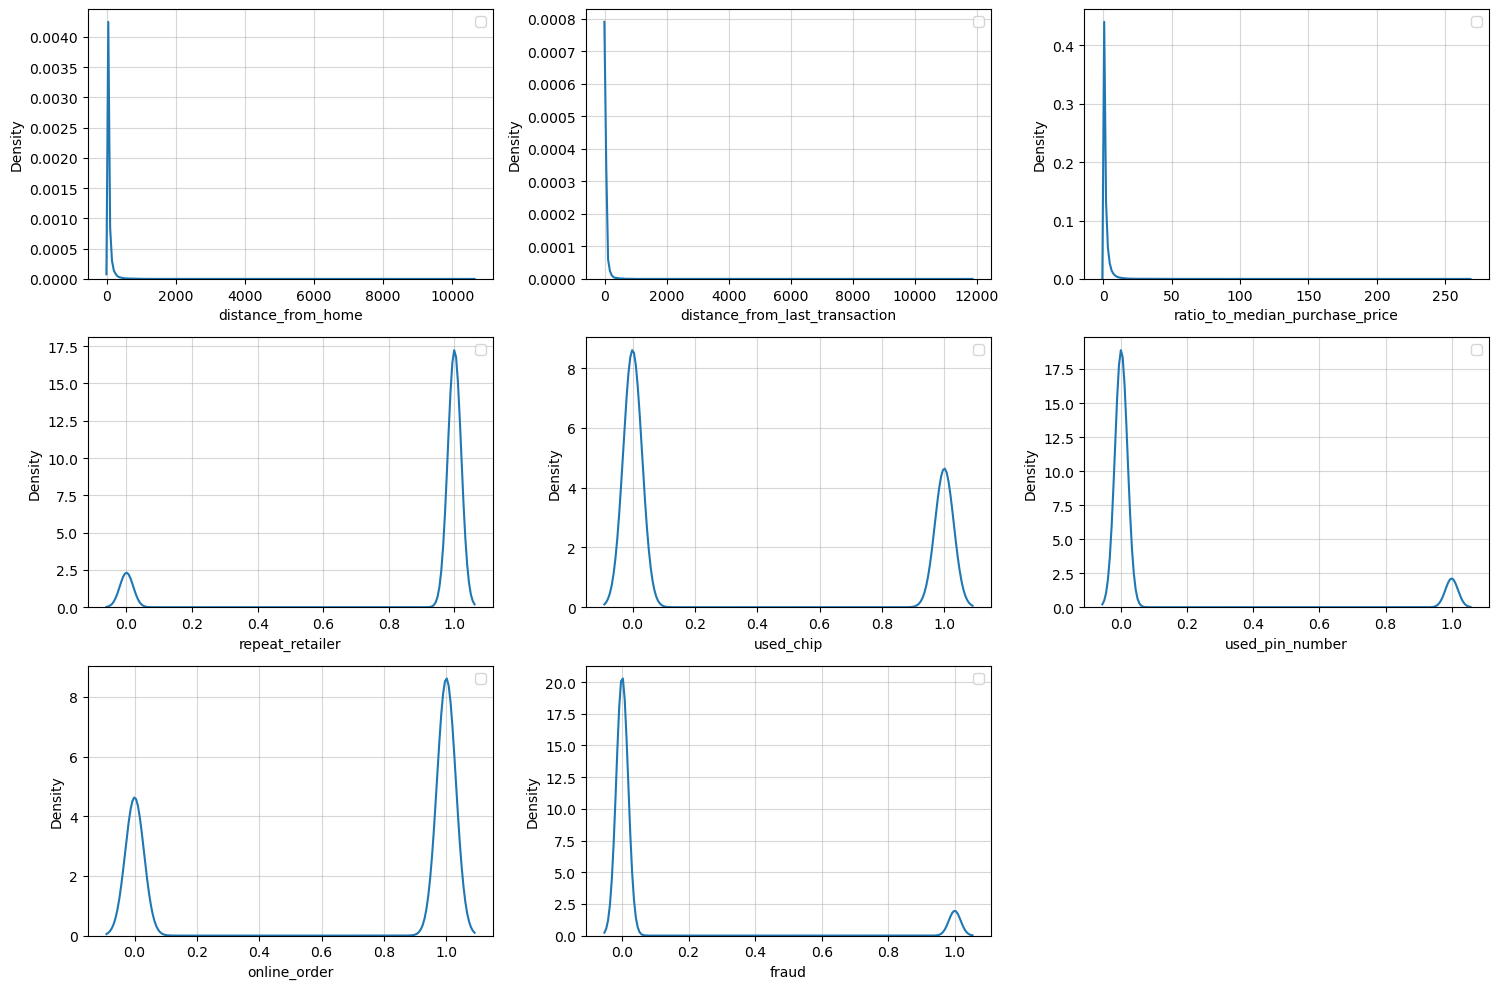

In [10]:
fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(df_credit_card_fraud_org.loc[:, 'distance_from_home' : 'fraud'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = df_credit_card_fraud_org)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Overcome Train/Test Split Challenge by Creating New Feature based on used_chip & used_pin_number

As demonstrated in the density graph, we observe the categorical features are somewhat skewed, so we need to ensure the "stratify" feature in train_test_split is leveraged to make sure the same skewness is preserved in the train/test datasets.

However, if I include all 5 original categorical features (even with a low test sample size out of 1MM samples), it will report error since the stratificaion strategy can't find a "good" data split that satisfy all the "Train/Test" requirements, ie, a split that maintains all the observed data value proportions

Because of this discovery, I create a new feature, called "card_present", based on the 2 features "used_chip" and "used_pin_number" as they both are considered as "card present" transaction, ie, the card holder/card is present at the point of sales (POS).

|  card_present  |  used_chip  |  used_pin_number  |
| -------------- | ----------- | ----------------- |
|       0        |    False    |     False         |
|       1        |    False    |     True          |
|       1        |    True     |     False         |
|       1        |    True     |     True          |

After this step, train / test split becomes successful.  A new feature called "id" is added to the dataset and it is a just a copy of the dataframe index.  After the train/test split becomes successful, we will leverage this "id" field and retrieve the rows from the original dataset.

In [11]:
print(df_credit_card_fraud_org['repeat_retailer'].value_counts())
print(df_credit_card_fraud_org['used_chip'].value_counts())
print(df_credit_card_fraud_org['used_pin_number'].value_counts())
print(df_credit_card_fraud_org['online_order'].value_counts())
print(df_credit_card_fraud_org['fraud'].value_counts())

dX = df_credit_card_fraud_org.loc[:, ~df_credit_card_fraud_org.columns.isin(["fraud"])].copy()
dY = df_credit_card_fraud_org['fraud']

# If we try to maintain all the categorical feature's proportions, the train/test split will fail
X_train, X_test, Y_train, Y_test = train_test_split(dX, dY, test_size=50, random_state=random_seed, shuffle=True, stratify=df_credit_card_fraud_org[['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']])

1.0    881536
0.0    118464
Name: repeat_retailer, dtype: int64
0.0    649601
1.0    350399
Name: used_chip, dtype: int64
0.0    899392
1.0    100608
Name: used_pin_number, dtype: int64
1.0    650552
0.0    349448
Name: online_order, dtype: int64
0.0    912597
1.0     87403
Name: fraud, dtype: int64


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [12]:
# 1. Make a copy of the original dataset
# 2. Create card_present feature.  card_present feature is a combination of used_chip & used_pin_number features as they both will only be true when the card holder/card is present
# 3. Drop the used_chip & used_pin_number features from this intermediate dataset

df_credit_card_fraud_cleaned_stratification_step01 = df_credit_card_fraud_org.copy()

df_credit_card_fraud_cleaned_stratification_step01['card_present'] = df_credit_card_fraud_cleaned_stratification_step01[['used_chip', 'used_pin_number']].max(axis=1)
df_credit_card_fraud_cleaned_stratification_step01.drop(columns=['used_chip', 'used_pin_number'], inplace=True)

df_credit_card_fraud_cleaned_stratification_step01.head(20)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,online_order,fraud,card_present
0,57.877857,0.311140,1.945940,1.0,0.0,0.0,1.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,1.0,0.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,1.0,0.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,0.0,1.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,1.0,0.0,0.0


In [13]:
# With the new card_present feature, the train/test split is successful

# dX = df_credit_card_fraud_cleaned_stratification_step01.loc[:, ~df_credit_card_fraud_cleaned_stratification_step01.columns.isin(["fraud"])].copy()
# dY = df_credit_card_fraud_cleaned_stratification_step01.loc[:, ['fraud']].copy()

X_train, X_test, Y_train, Y_test = train_test_split(dX, dY, test_size=0.1, random_state=random_seed, shuffle=True, stratify=df_credit_card_fraud_cleaned_stratification_step01[['repeat_retailer', 'online_order', 'card_present', 'fraud']])


# Data Cleaning - Overcome Imbalance Data Challenge by Applying SMOTE Technique

Valid tx count:912597, Fraudulent tx count: 87403


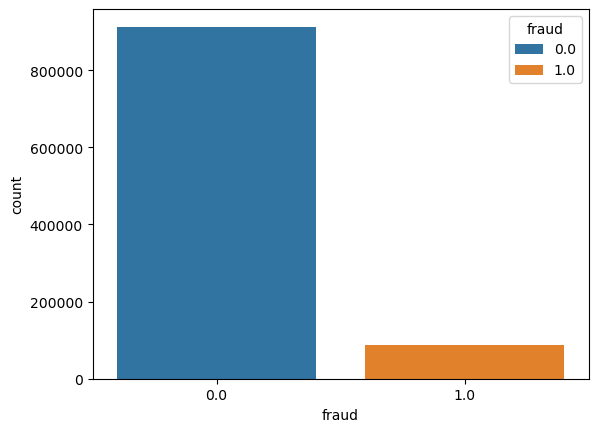

In [14]:
fraud_count = df_credit_card_fraud_org["fraud"].value_counts().tolist()
print(f"Valid tx count:{fraud_count[0]}, Fraudulent tx count: {fraud_count[1]}")

sns.countplot(x = 'fraud', data = df_credit_card_fraud_org, hue='fraud', stat='count', legend='auto')
plt.show()

#### Data Cleaning - Fix imbalance data

As the previous diagram confirms our observation from df.describe() and common intuition, the data is imbalance.  With fraudulent ratio around ~9.578%, even without a model, we will be able to guess >90% that a transaction isn't fraudulent.

To fix it, we can either choose under-sampling or over-sampling.  However, since the majority of the dataset are "valid" transactions, if we take the under-sampling route, it will significantly lower the overall data population size and it can potentially drop useful data too, so I think over-sampling will be a better route, ie, the minority data is artifically re-introduced into the dataset for training purpose.

However, after further research, I found out there is a technique called "Synthetic Minority Over-sampling Technique", aka "SMOTE", published by N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer at https://arxiv.org/abs/1106.1813.

Even better, the technique has been implemented in Python package called "imbalanced-learn" at https://imbalanced-learn.org/stable/index.html as a result of "Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning" by Guillaume Lemaître, Fernando Nogueira, Christos K. Aridas.

This technique's goal is aimed at improving the performance of the model, so this technique will only be applied to the training dataset (e.g. X_train)







In [92]:
print(X_train.columns)

cat_feature_index = X_train.columns.get_indexer(['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order'])
print(cat_feature_index)

# create new X/Y_train and call them X_oversampled
smotenc = SMOTENC(cat_feature_index, random_state=random_seed)
X_oversampled, Y_oversampled = smotenc.fit_resample(X_train, Y_train)



Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order'],
      dtype='object')
[3 4 5 6]


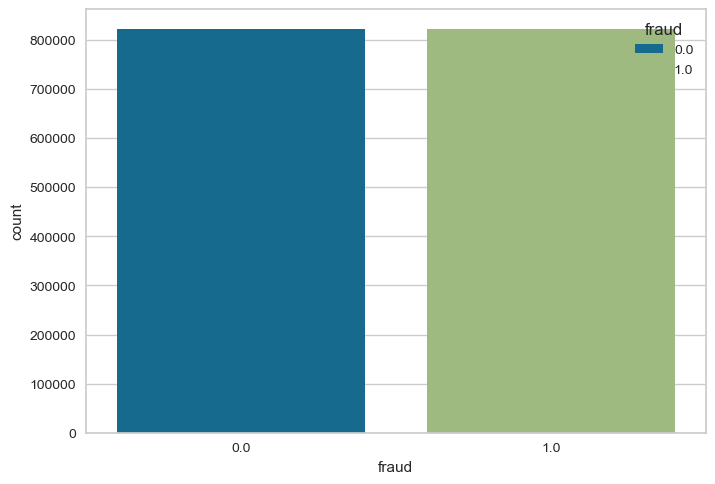

In [93]:
# Validate the population of the new oversampled dataset

sns.countplot(x = 'fraud', data = Y_oversampled.to_frame(), hue='fraud', stat='count', legend='auto')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

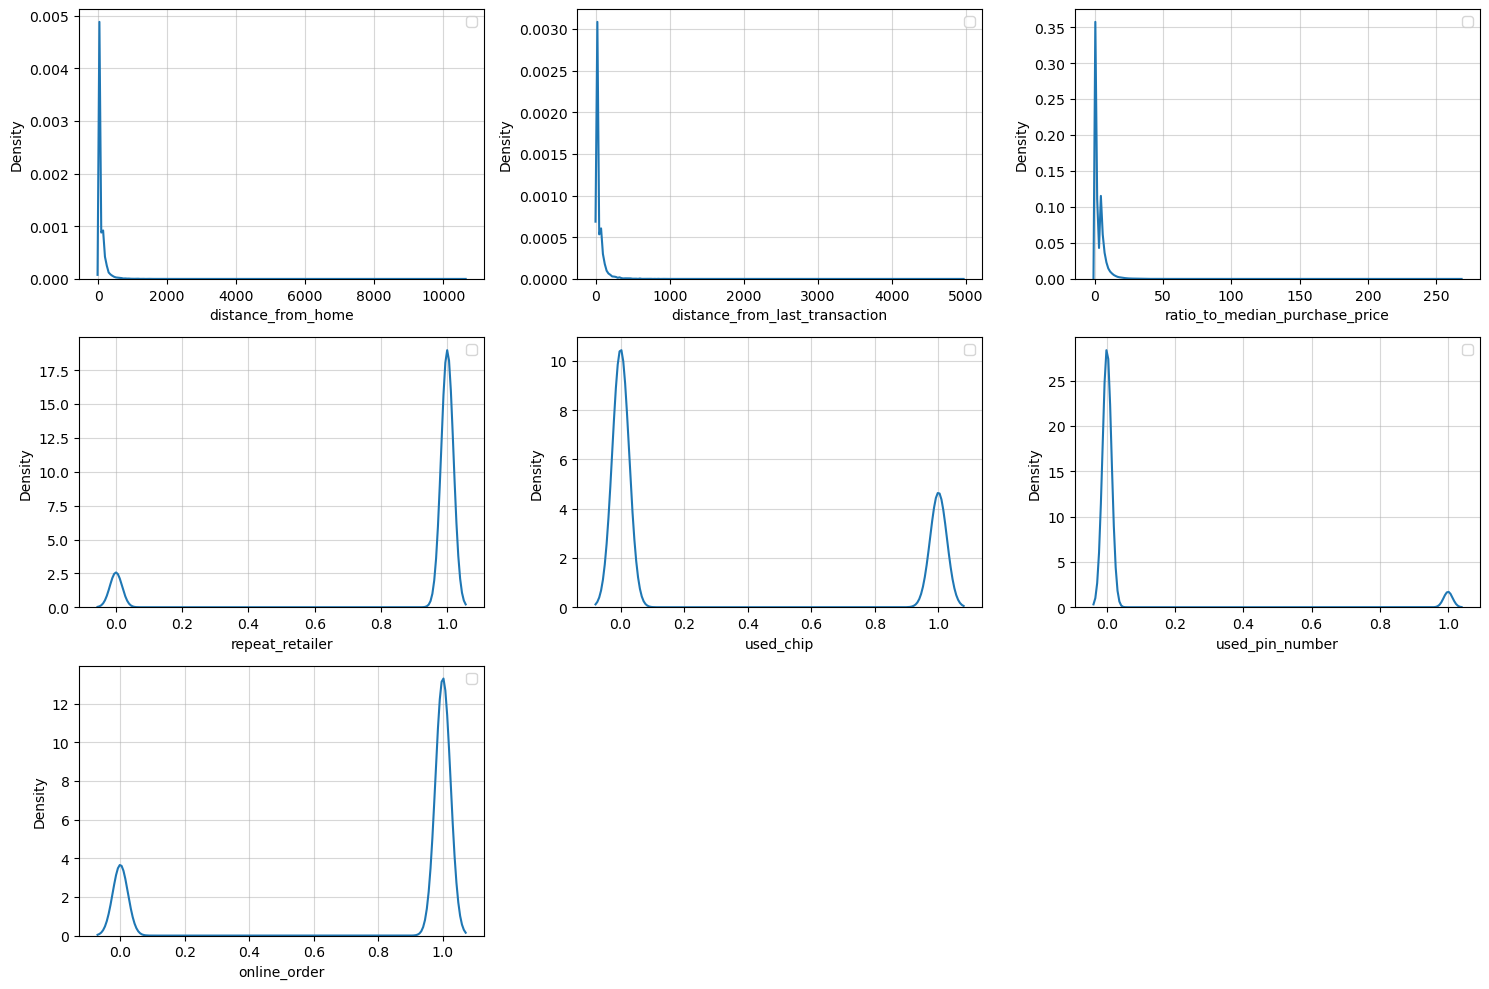

In [17]:
# Spot check the density of the new X_oversampled dataset

fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(X_oversampled.loc[:, 'distance_from_home' : 'online_order'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = X_oversampled)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Overcome Data Scale Challenge by Using Logarithm Method

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

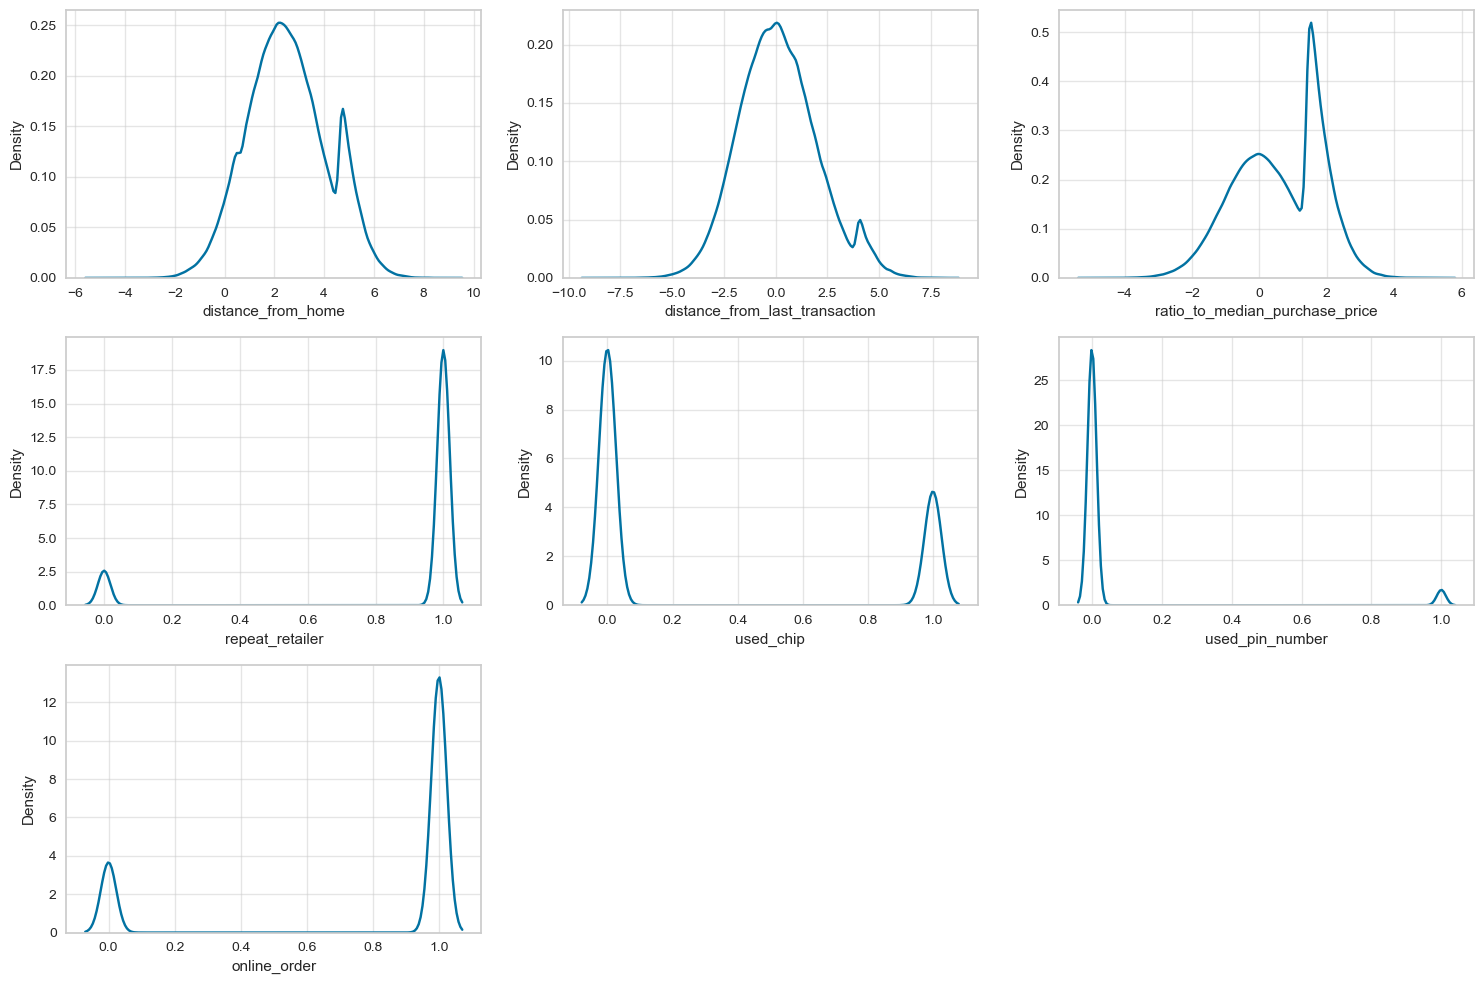

In [94]:
# Apply Logarithm to the "distance_from_home", "distance_from_last_transation" and "ratio_to_median_purchase_price" features

X_oversampled_scaled_log = X_oversampled.copy()
Y_oversampled_scaled_log = Y_oversampled.copy()

X_oversampled_scaled_log['distance_from_home'] = np.log(X_oversampled_scaled_log['distance_from_home'])
X_oversampled_scaled_log['distance_from_last_transaction'] = np.log(X_oversampled_scaled_log['distance_from_last_transaction'])
X_oversampled_scaled_log['ratio_to_median_purchase_price'] = np.log(X_oversampled_scaled_log['ratio_to_median_purchase_price'])

# Spot check the density of the new X_oversampled_scaled_log dataset, and the charts confirmed the "tails" are "pulled" back

fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(X_oversampled_scaled_log.loc[:, 'distance_from_home' : 'online_order'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = X_oversampled_scaled_log)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Overcome Data Scale Challenge by Using SQRT Method

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

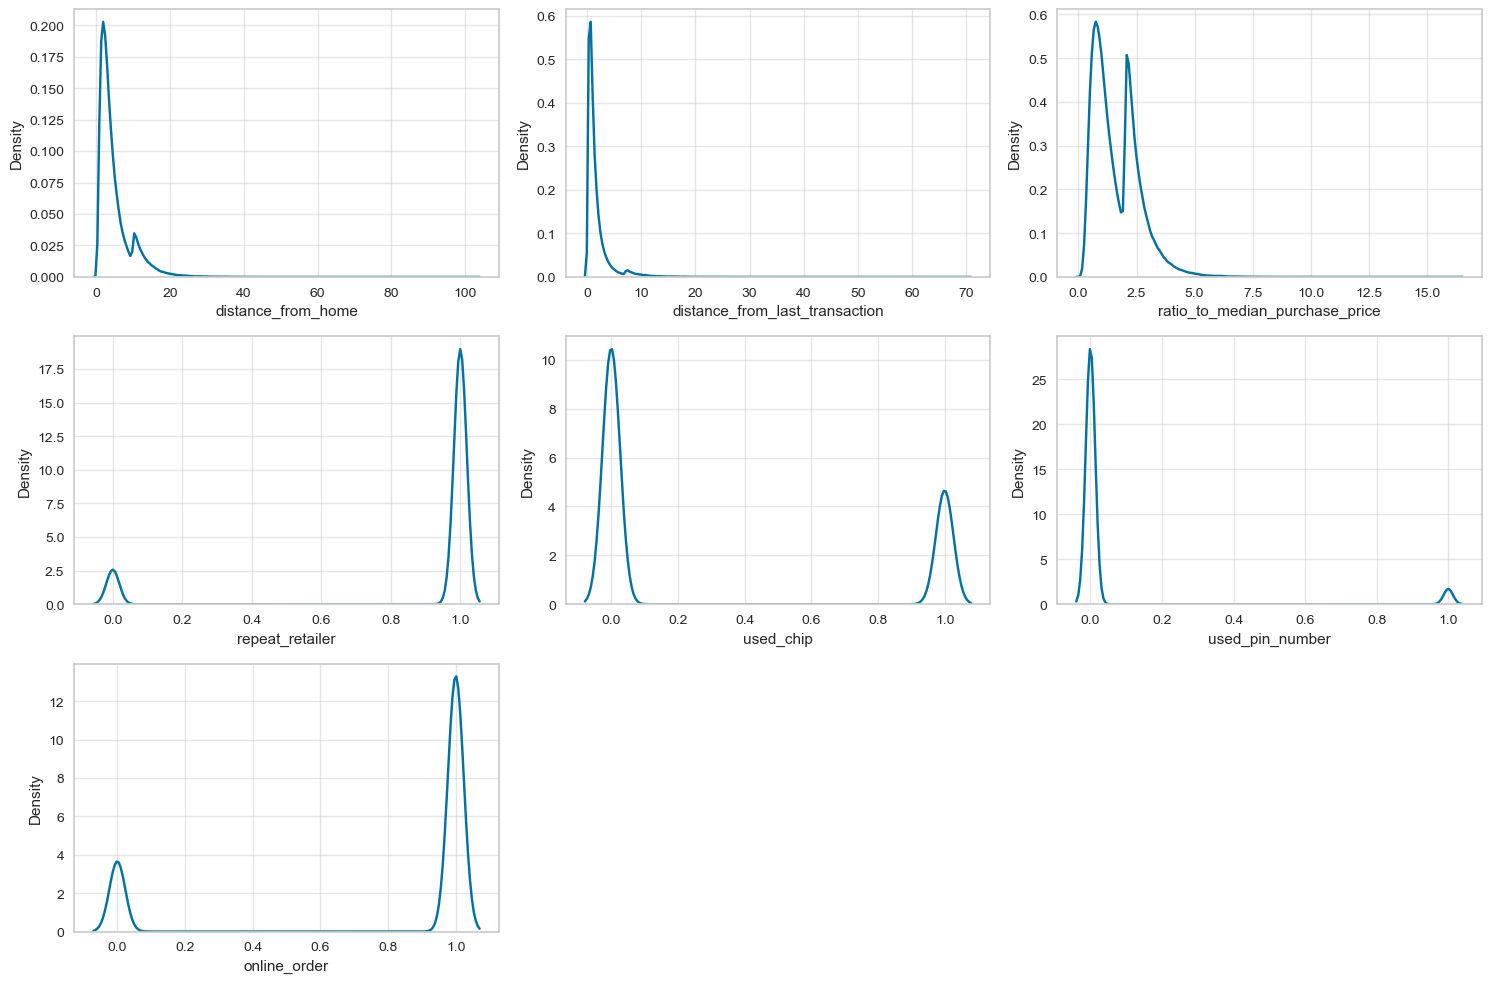

In [95]:
# Apply sqrt to the "distance_from_home", "distance_from_last_transation" and "ratio_to_median_purchase_price" features

X_oversampled_scaled_sqrt = X_oversampled.copy()
Y_oversampled_scaled_sqrt = Y_oversampled.copy()

X_oversampled_scaled_sqrt['distance_from_home'] = np.sqrt(X_oversampled_scaled_sqrt['distance_from_home'])
X_oversampled_scaled_sqrt['distance_from_last_transaction'] = np.sqrt(X_oversampled_scaled_sqrt['distance_from_last_transaction'])
X_oversampled_scaled_sqrt['ratio_to_median_purchase_price'] = np.sqrt(X_oversampled_scaled_sqrt['ratio_to_median_purchase_price'])

# Spot check the density of the new X_oversampled_scaled_log dataset, and the charts confirmed the "tails" are "pulled" back

fig = plt.figure(figsize=(15, 10))
rows, cols = 3, 3
for i, col_name in enumerate(X_oversampled_scaled_sqrt.loc[:, 'distance_from_home' : 'online_order'].columns):
  # print(f"{i}, {col_name}")
  ax = fig.add_subplot(rows, cols, i+1)
  ax.grid(alpha=0.5, axis='both')
  sns.kdeplot(x = col_name, data = X_oversampled_scaled_sqrt)
  ax.set_xlabel(col_name)
  ax.legend()

fig.tight_layout()
fig.show()

# Data Cleaning - Unforseen Problems / Conclusion

Unforseen challenge:
1. Test / Train split stratification error

*   If I include all 5 original categorical features and with a typical 0.2 test size, then it will report error since the stratificaion strategy can't find a "good" data split that satisfy all the Train / Test requirements, ie, train / test size, all the features that need to be stratified and all the observed data value proportions
*   Because of this discovery, we have to create a new feature to complete the train/test split step

Forseen challenge:
2.  Fraud occurence is expected to be minority
*    Over-sampling technique is needed
*    SMOTE is a better approach compared to the traditional "random" over-sampling technique

3.  From the density charts, the continuous features "distance_from_home", "distance_from_last_transation" and "ratio_to_median_purchase_price" are right-skewed

*    As the range is beyond 99% percentile, I applied the Logarithm method to these features and successfully "pull" the tails towards the center
*    With this scaling, we are ready for various classification algorithms that are "sensitive" to the scale / range of the continuous features



In [20]:
XY_oversampled = pd.concat([X_oversampled, Y_oversampled], axis='columns')
XY_oversampled.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1.642674e+06,1.642674e+06,1.642674e+06,1.642674e+06,1.642674e+06,1.642674e+06,1.642674e+06,1642674.0
mean,2.549519e+00,1.500877e-01,6.179302e-01,8.807177e-01,3.076727e-01,5.643847e-02,7.846073e-01,0.5
std,1.611526e+00,1.900358e+00,1.283329e+00,3.241205e-01,4.615304e-01,2.307665e-01,4.110946e-01,0.5
min,-5.323761e+00,-9.042442e+00,-5.160111e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.421051e+00,-1.162161e+00,-3.651872e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0
50%,2.462123e+00,5.009258e-02,6.888576e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.5
75%,3.628663e+00,1.329919e+00,1.652708e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.0
max,9.271692e+00,8.510836e+00,5.590251e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0


# EDA - Check for correlation among features


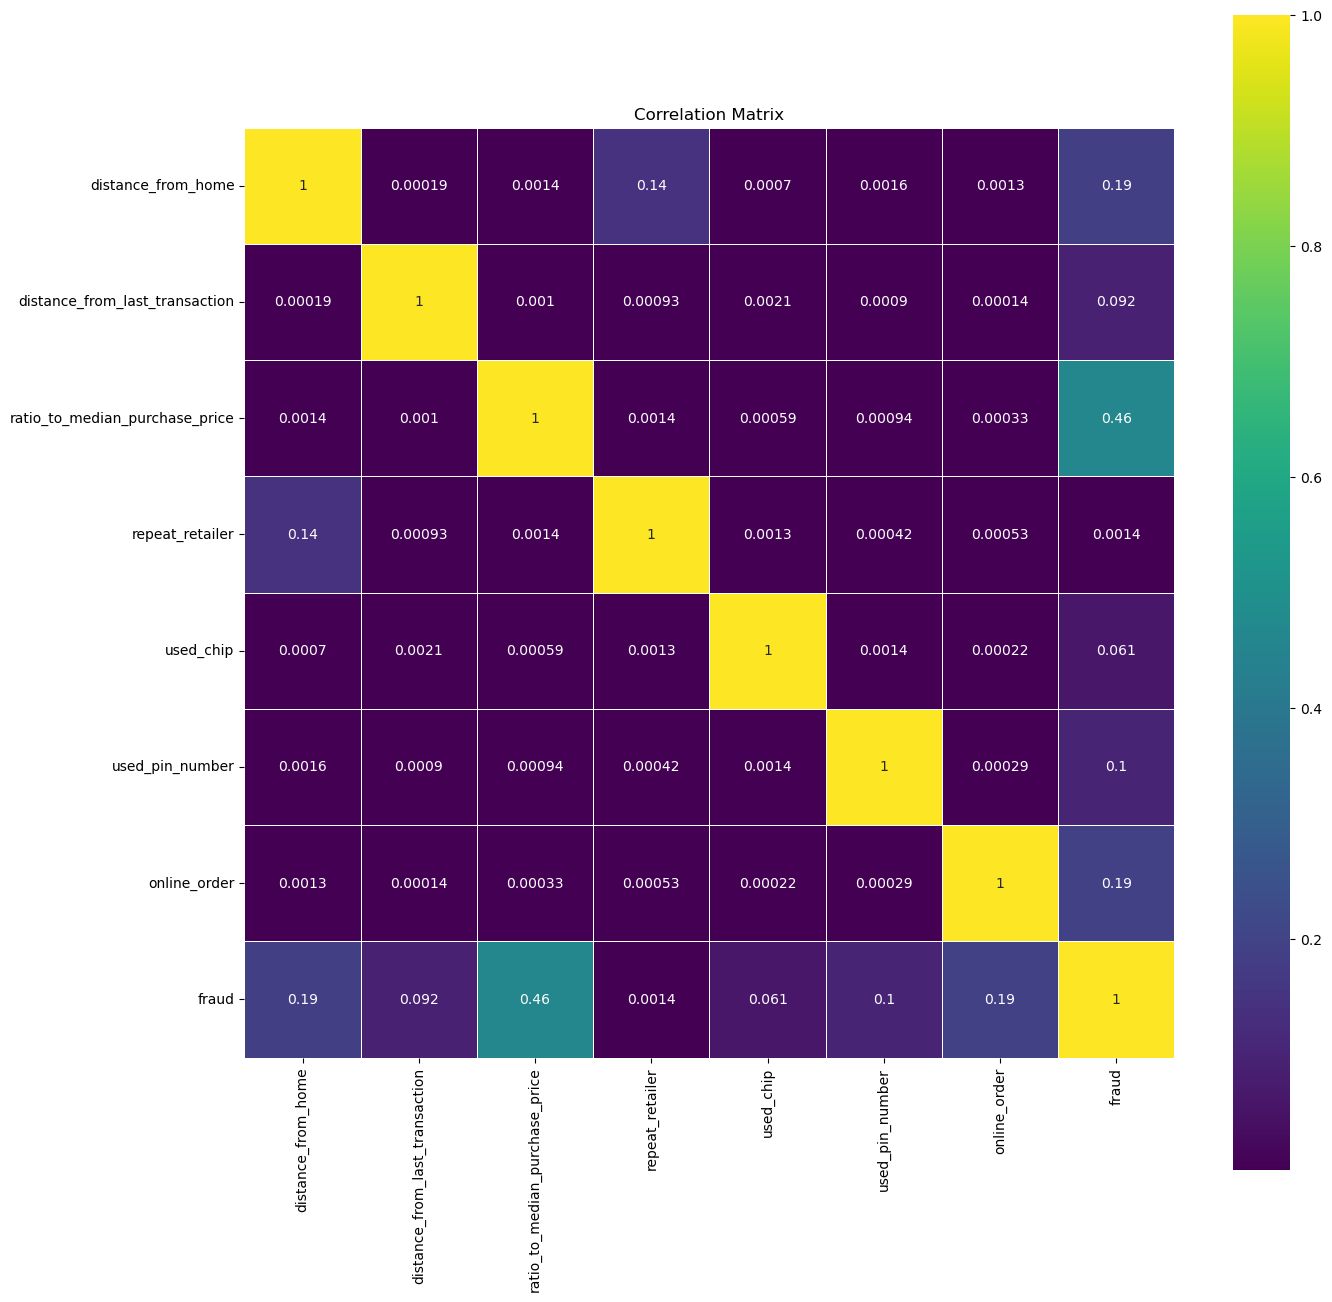

In [21]:
plt.figure(figsize = (15, 15))
plt.title("Correlation Matrix")
corr_matrix = df_credit_card_fraud_org.corr().abs()
sns.heatmap(corr_matrix, annot=True, robust=True, cmap="viridis", linewidths=0.5, square=True)
plt.show()

## EDA - Correlation Chart Analysis & Conslusion

1. Out of the 7 independent features (3 continuous and 4 categorical), from the correlation chart, there isn't a feature that shows strong correlation relationship with our dependent feature - fraud
2. With a correlation chart, it isn't expected to show a linear relationship with the categorical features
3. However, we will investigate more w/ the 3 features that show higher correlation values, ie, 1) distance_from_home; 2) ratio_to_median_purchase_price; 3) online_order

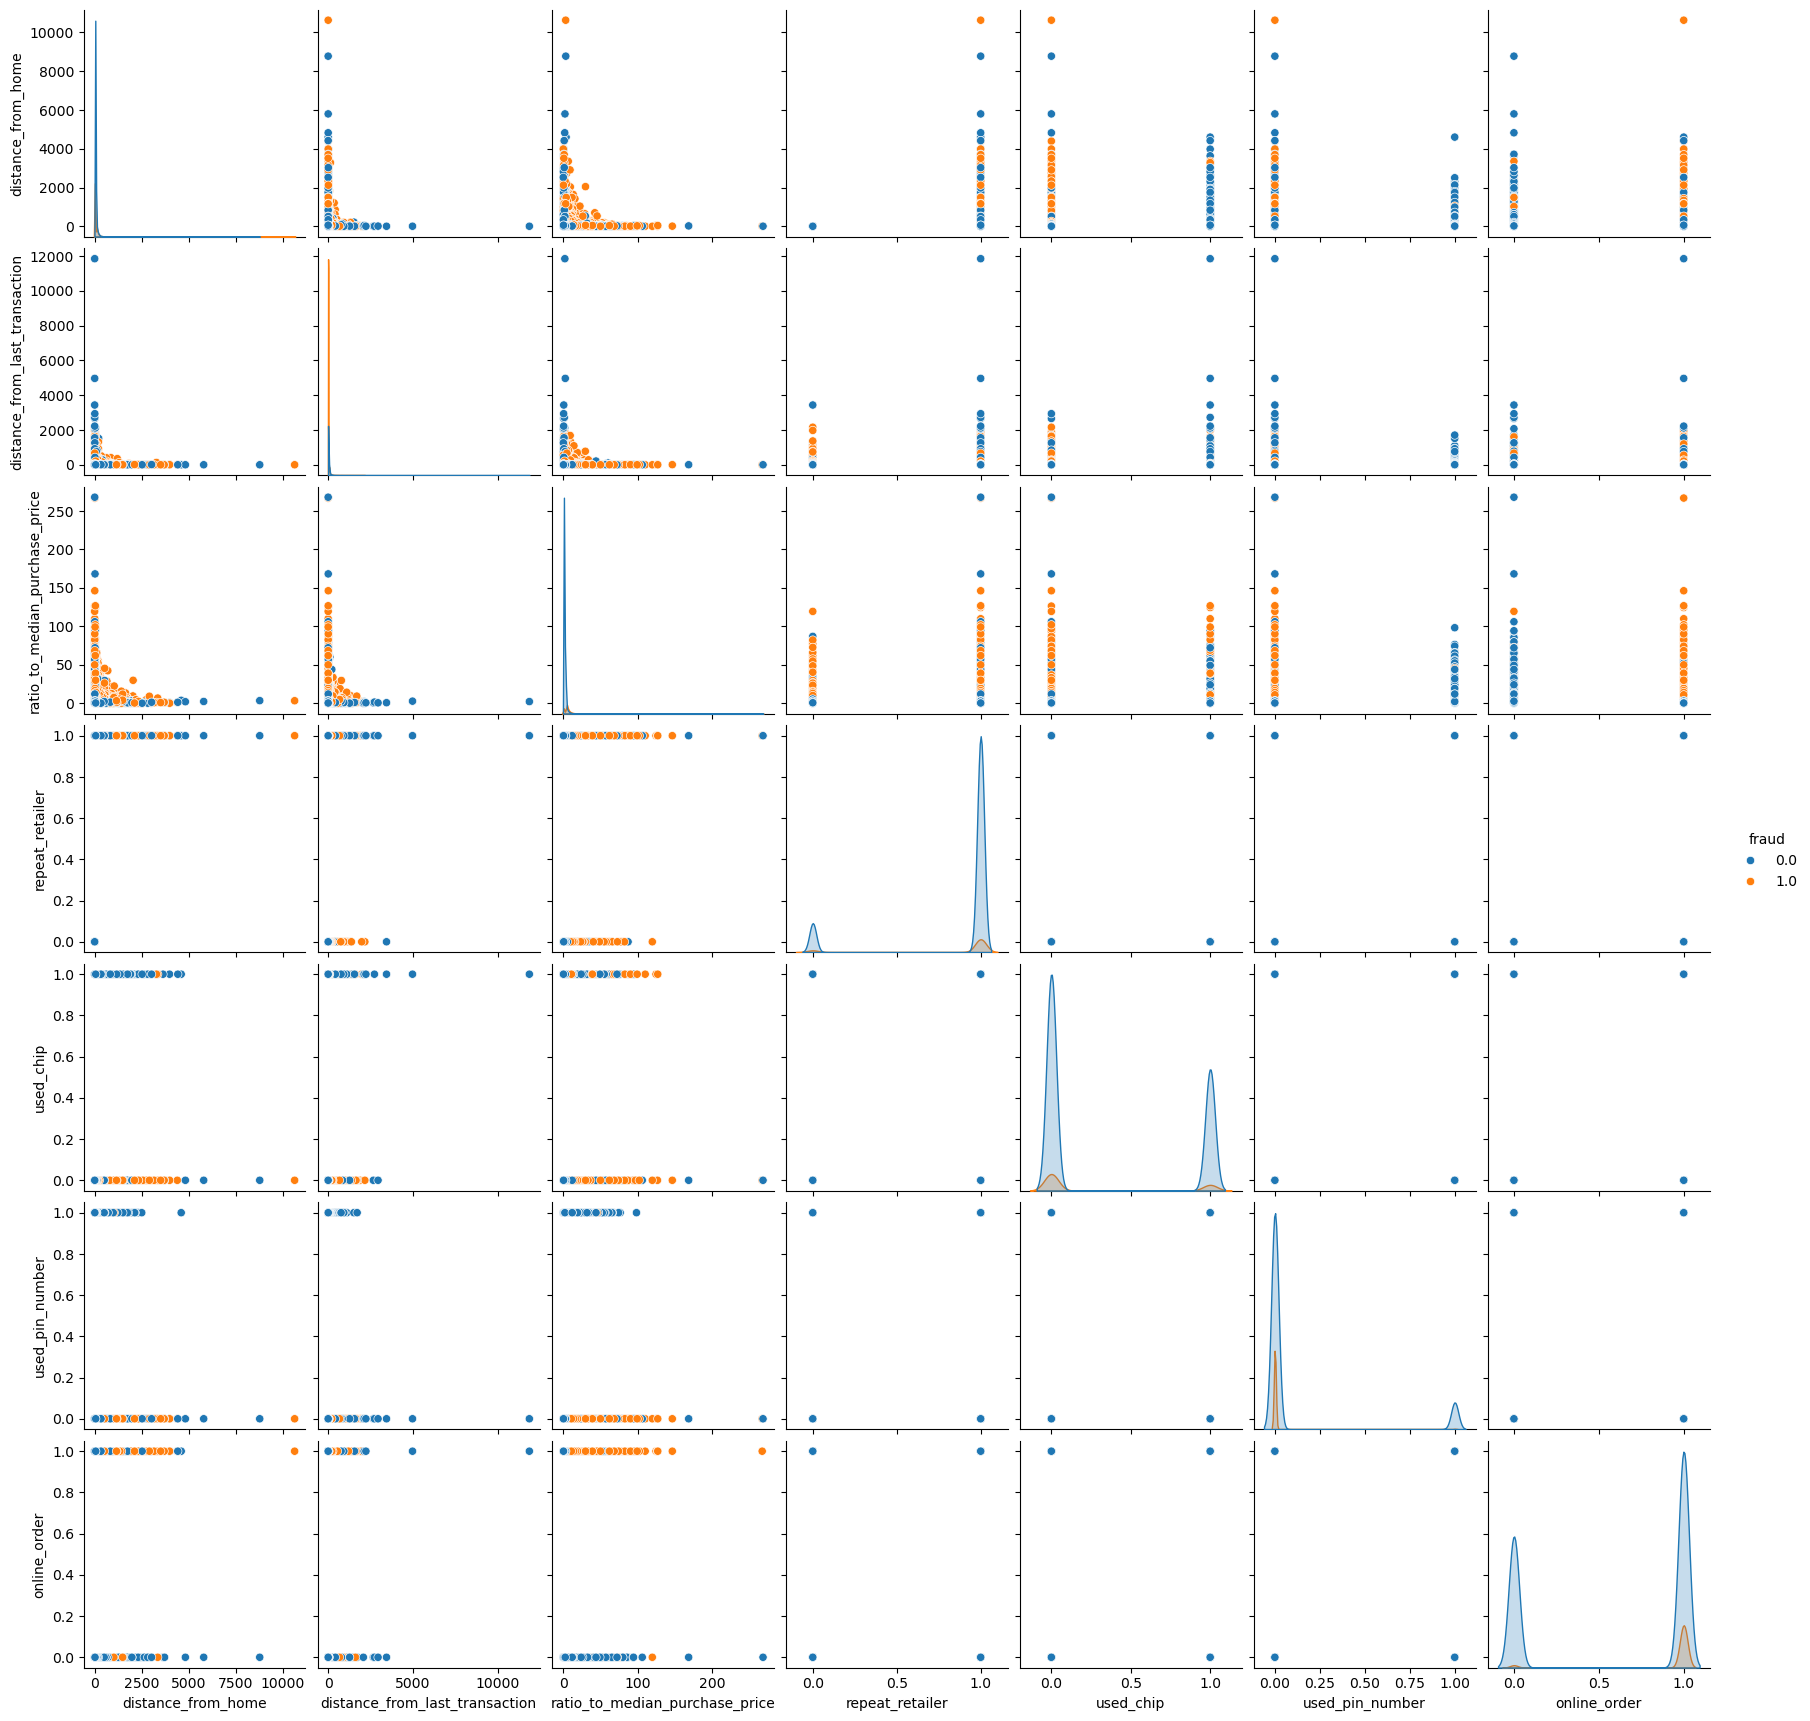

In [22]:
sns.pairplot(df_credit_card_fraud_org[df_credit_card_fraud_org.columns], diag_kind='kde', hue='fraud')
plt.show()

## EDA - Pairplot Analysis & Conslusion

From the pairplot, the following characteristics are observed:
a) fraud happens more frequent when:
i) NOT used_chip
ii) NOT used_pin_number
iii) likely to be online_order

None of the continuous features seem to be "strong" indicator of fraud, as fraud (location of the amber dots) and non-fraud (location of the blue dots) are showing along the axises.  So, not a strong indicator of fraud.


[Text(0.49609375, 0.9375, 'ratio_to_median_purchase_price <= 4.0\ngini = 0.16\nsamples = 1000000\nvalue = [912597, 87403]'),
 Text(0.20833333333333334, 0.8125, 'distance_from_home <= 100.004\ngini = 0.049\nsamples = 896842\nvalue = [874390, 22452]'),
 Text(0.09375, 0.6875, 'distance_from_last_transaction <= 50.028\ngini = 0.012\nsamples = 852163\nvalue = [847102, 5061]'),
 Text(0.041666666666666664, 0.5625, 'distance_from_last_transaction <= 50.001\ngini = 0.0\nsamples = 839540\nvalue = [839539, 1]'),
 Text(0.020833333333333332, 0.4375, 'gini = 0.0\nsamples = 839531\nvalue = [839531, 0]'),
 Text(0.0625, 0.4375, 'distance_from_last_transaction <= 50.004\ngini = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(0.041666666666666664, 0.3125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.08333333333333333, 0.3125, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.14583333333333334, 0.5625, 'online_order <= 0.5\ngini = 0.48\nsamples = 12623\nvalue = [7563.0, 5060.0]'),
 Text(0.125, 0.4375

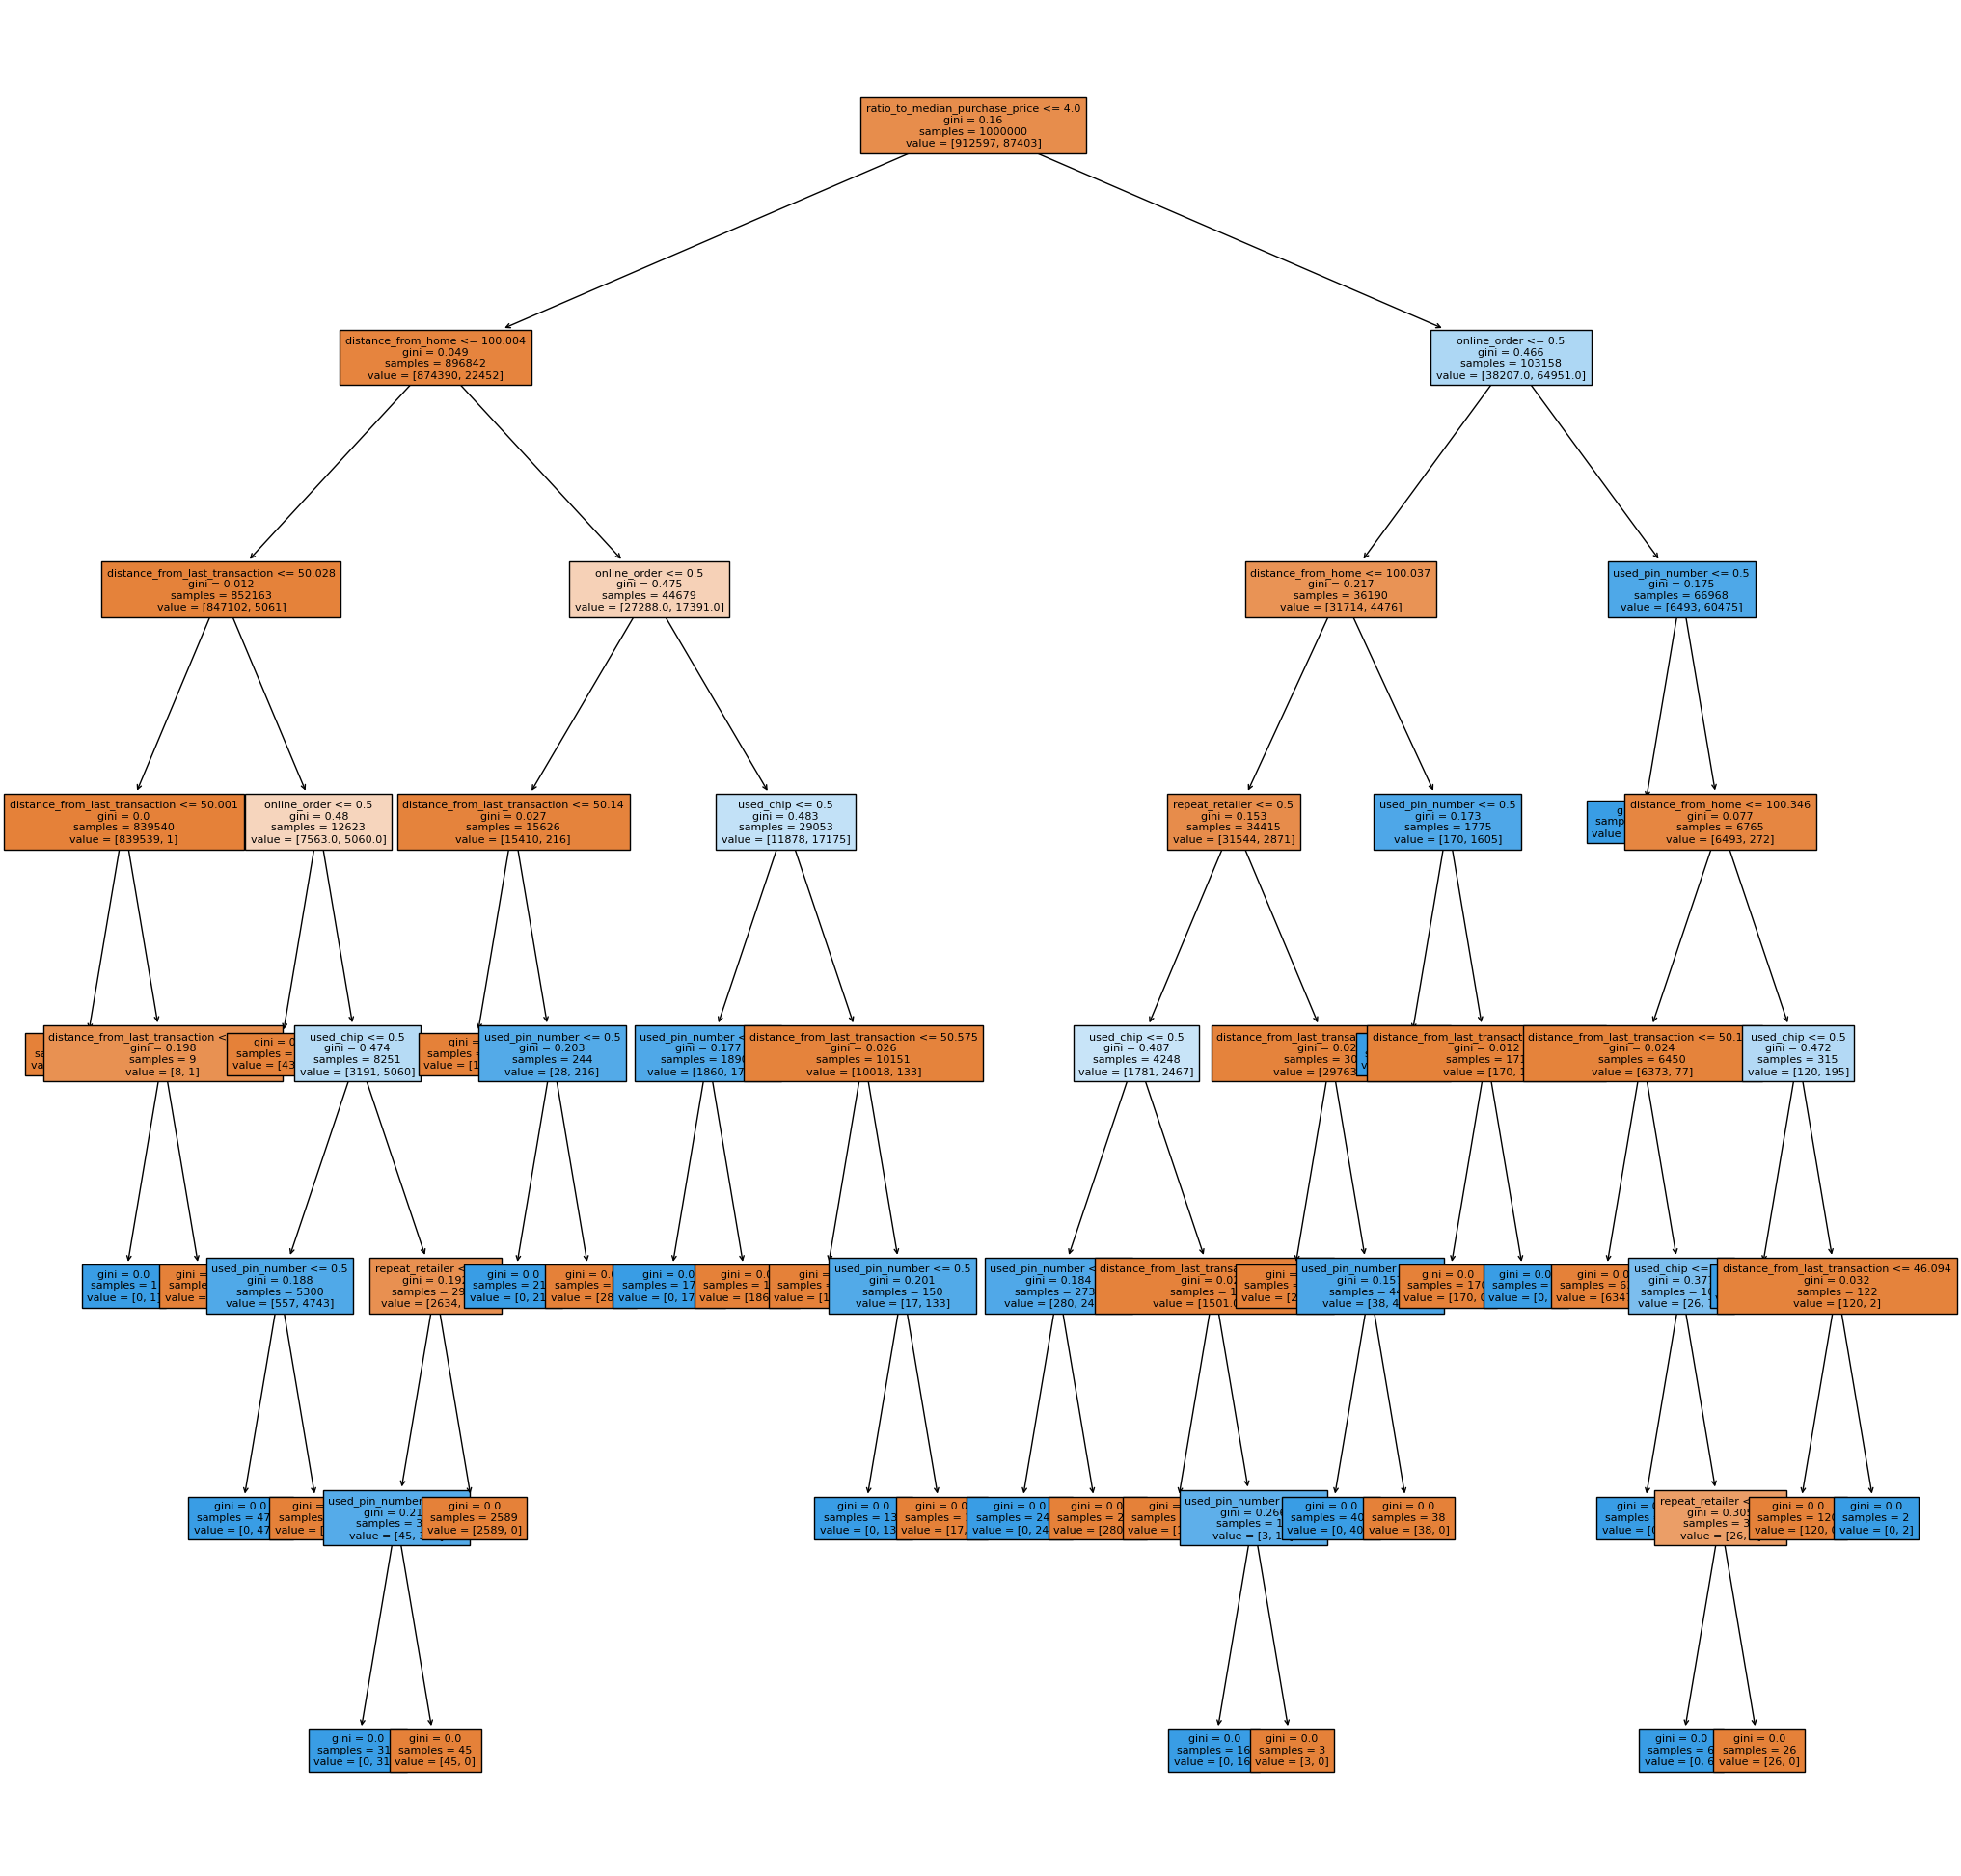

In [33]:
eda_X = df_credit_card_fraud_org[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']]
eda_Y = df_credit_card_fraud_org['fraud']

dt = DecisionTreeClassifier().fit(eda_X, eda_Y)

plt.figure(figsize=(25, 25))
plot_tree(dt, filled=True, feature_names=eda_X.columns, max_depth=10, fontsize=8)

<Figure size 1000x1000 with 0 Axes>

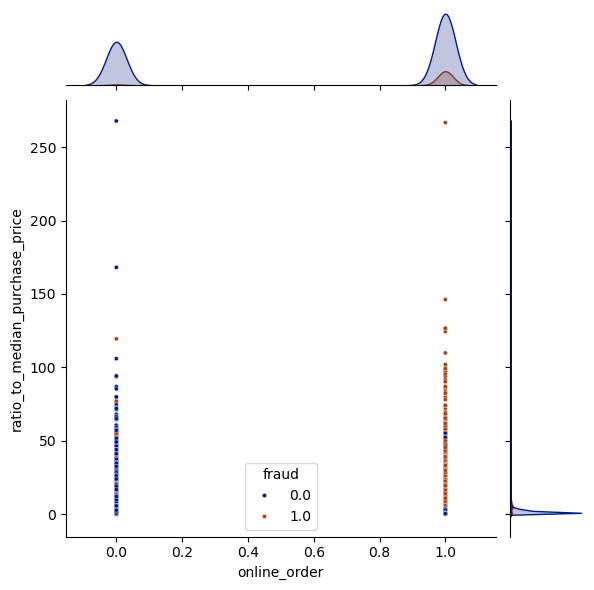

In [21]:
plt.figure(figsize=(10,10))
sns.jointplot(x='online_order', y='ratio_to_median_purchase_price',hue='fraud', data=df_credit_card_fraud_org, palette='dark', s=9)

# EDA - Decision Tree (DT) Analysis & Conclusion

By leveraging DT, it provides another angle of evaluating how the various features influence the fraud status of a transaction. At a glance, we can see if the transaction is ~4 times more than the meidan purchase price, it is more likely to be a fradulent (higher risk).  Following the DT, one can visualize in the above diagram that, if the transaction is also an "online order", then the fraud indicators (amber dots) are dominating.

# EDA - Collinearity / MultiCollinearity

### Determine collinearity / multicollinearity

Rationale: Although this is not a regression problem, some classification algorithms' performance can be impacted as those algorithm assumes independence of features or linear relationship between the features.  For example, Logistic Regression, it is a type of linear model so collinearity / multicollinearity will affect its performance.



In [44]:
# Calculate Variance Inflation Factor (VIF) to detect if there is hidden trace of collinearity / multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

_y, _X = dmatrices('fraud ~ distance_from_home+distance_from_last_transaction+ratio_to_median_purchase_price+repeat_retailer+used_chip+used_pin_number+online_order', data=df_credit_card_fraud_org, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(_X.values, i) for i in range(_X.shape[1])]
vif['variable'] = _X.columns

In [42]:
# Examine VIF (the values are low) and confirm collinearity / multicollinearity will not be a concern.  
# With this confirmation, we can choose various classification algorithm including Linear Regression

vif

,VIF,variable
0,11.423736,Intercept
1,1.020920,distance_from_home
2,1.000007,distance_from_last_transaction
3,1.000007,ratio_to_median_purchase_price
4,1.020918,repeat_retailer
5,1.000009,used_chip
6,1.000006,used_pin_number
7,1.000002,online_order


# Model
Since we are going to classify whether a credit card transaction is fradulent or not, we will try 3 classification algorithm:
1. Random Forest Classifier from the "Ensemble" family
2. Decision Tree Classifier from the "Tree" family
3. K-Neighbors Classifier from the "Neighbor" family

## Model Selection
PyCaret (https://pycaret.org/) is a low code machine learning framework that we can leverage to quickly get a sense of various model performance with very limited coding.

This framework was used as a "speed-test" to get a directional sense of model selection.

In [173]:
caret_setup_raw = setup(df_credit_card_fraud_org, target = 'fraud', session_id = random_seed)

,Description,Value
0,Session id,202406
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(1000000, 8)"
4,Transformed data shape,"(1000000, 8)"
5,Transformed train set shape,"(700000, 8)"
6,Transformed test set shape,"(300000, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [174]:
best_mdl_comparison_raw = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,1.0000,0.9999,0.9998,1.0000,0.9999,0.9999,0.9999,0.6110
rf,Random Forest Classifier,1.0000,1.0000,0.9999,1.0000,0.9999,0.9999,0.9999,17.6820
ada,Ada Boost Classifier,0.9997,1.0000,0.9989,0.9982,0.9986,0.9984,0.9984,9.4770
gbc,Gradient Boosting Classifier,0.9997,1.0000,0.9977,0.9993,0.9985,0.9984,0.9984,38.2140
et,Extra Trees Classifier,0.9995,1.0000,0.9952,0.9990,0.9971,0.9969,0.9969,10.0350
lightgbm,Light Gradient Boosting Machine,0.9989,1.0000,0.9953,0.9920,0.9936,0.9930,0.9930,1.8950
knn,K Neighbors Classifier,0.9825,0.9946,0.9195,0.8850,0.9019,0.8923,0.8925,3.6030
svm,SVM - Linear Kernel,0.9606,0.9353,0.7321,0.8015,0.7646,0.7431,0.7444,8.7400
lr,Logistic Regression,0.9586,0.9667,0.5986,0.8919,0.7164,0.6950,0.7111,3.2130
qda,Quadratic Discriminant Analysis,0.9576,0.9662,0.6627,0.8172,0.7318,0.7091,0.7137,0.3620


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [175]:
caret_setup_oversampled = setup(XY_oversampled, target = 'fraud', session_id = random_seed)

,Description,Value
0,Session id,202406
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(1642674, 8)"
4,Transformed data shape,"(1642674, 8)"
5,Transformed train set shape,"(1149871, 8)"
6,Transformed test set shape,"(492803, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [176]:
best_mdl_comparison_oversampled = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,0.9999,1.0000,1.0000,0.9999,0.9999,36.1250
dt,Decision Tree Classifier,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,0.9999,1.3110
et,Extra Trees Classifier,0.9993,1.0000,0.9999,0.9987,0.9993,0.9987,0.9987,17.0570
lightgbm,Light Gradient Boosting Machine,0.9985,1.0000,0.9992,0.9978,0.9985,0.9970,0.9970,3.0320
ada,Ada Boost Classifier,0.9979,1.0000,0.9999,0.9960,0.9979,0.9958,0.9958,15.8260
gbc,Gradient Boosting Classifier,0.9977,1.0000,0.9998,0.9956,0.9977,0.9955,0.9955,60.7120
knn,K Neighbors Classifier,0.9953,0.9988,0.9998,0.9910,0.9953,0.9906,0.9907,6.1750
lr,Logistic Regression,0.8711,0.9462,0.8895,0.8580,0.8735,0.7423,0.7428,1.6860
svm,SVM - Linear Kernel,0.8710,0.9463,0.8924,0.8560,0.8737,0.7420,0.7429,0.5480
ridge,Ridge Classifier,0.8654,0.9451,0.9172,0.8310,0.8720,0.7307,0.7347,0.2820


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

Based on PyCaret's "quick test", it seems that Oversampled dataset provides slightly better Recall rate (since we are trying to classify fraudulent transactions, so we want to minimize false negative).


In [120]:
_dY = dY.to_frame()

fraud_count = _dY.value_counts()[1]
nonfraud_count = _dY.value_counts()[0]

fraud_weight = nonfraud_count / _dY.shape[0]
nonfraud_weight = fraud_count / _dY.shape[0]
print(fraud_weight)
print(nonfraud_weight)

adj_class_weight = {0 : nonfraud_weight, 1: fraud_weight}

0.912597
0.087403


## Model - Random Forest Classifier

In [125]:
# Model - Feature Engineering (scaling w/ log()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Random Forest Classifier with "No class weight" (Oversample + scaling w/ log())

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

mdl_rf_oversample_log = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)
mdl_rf_oversample_log.fit(X_oversampled_scaled_log, Y_oversampled_scaled_log)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)

Precision of RF (oversample + log) validated w/ test set::0.15198636332011412
Recall of RF (oversample + log) validated w/ test set::0.9997711670480549
F1 of RF (oversample + log) validated w/ test set::0.26386036960985626


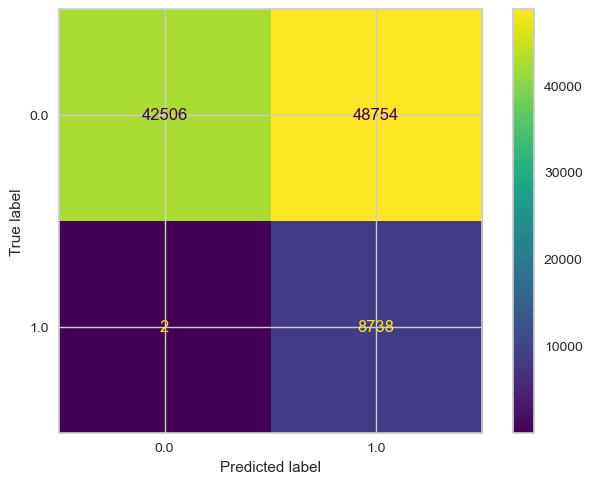

In [157]:
# Performance - Random Forest Classifier with "No class weight" (Oversample + scaling w/ log())

y_pred_rf_oversample_log = mdl_rf_oversample_log.predict(X_test)
print(f"Precision of RF (oversample + log) validated w/ test set::{metrics.precision_score(Y_test, y_pred_rf_oversample_log)}")
print(f"Recall of RF (oversample + log) validated w/ test set::{metrics.recall_score(Y_test, y_pred_rf_oversample_log)}")
print(f"F1 of RF (oversample + log) validated w/ test set::{metrics.f1_score(Y_test, y_pred_rf_oversample_log)}")

cm=metrics.confusion_matrix(Y_test, y_pred_rf_oversample_log)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_rf_oversample_log.classes_)
disp.plot()
plt.show()

In [127]:
# Model - Feature Engineering (scaling w/ sqrt()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Random Forest Classifier with "No class weight" (Oversample + scaling w/ sqrt())

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

mdl_rf_oversample_sqrt = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)
mdl_rf_oversample_sqrt.fit(X_oversampled_scaled_sqrt, Y_oversampled_scaled_sqrt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)

Precision of RF (oversample + sqrt) validated w/ test set::0.21753957980683064
Recall of RF (oversample + sqrt) validated w/ test set::0.9998855835240275
F1 of RF (oversample + sqrt) validated w/ test set::0.35733562315996076


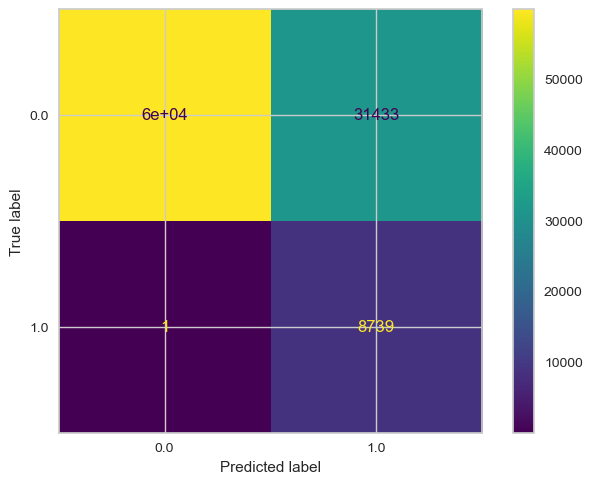

In [158]:
# Performance - Random Forest Classifier with "No class weight" (Oversample + scaling w/ sqrt())

y_pred_rf_oversample_sqrt = mdl_rf_oversample_sqrt.predict(X_test)
print(f"Precision of RF (oversample + sqrt) validated w/ test set::{metrics.precision_score(Y_test, y_pred_rf_oversample_sqrt)}")
print(f"Recall of RF (oversample + sqrt) validated w/ test set::{metrics.recall_score(Y_test, y_pred_rf_oversample_sqrt)}")
print(f"F1 of RF (oversample + sqrt) validated w/ test set::{metrics.f1_score(Y_test, y_pred_rf_oversample_sqrt)}")

cm=metrics.confusion_matrix(Y_test, y_pred_rf_oversample_sqrt)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_rf_oversample_sqrt.classes_)
disp.plot()
plt.show()

In [129]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Random Forest Classifier with "No class weight"

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

mdl_rf_oversample = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)
mdl_rf_oversample.fit(X_oversampled, Y_oversampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)

Precision of RF (oversample) validated w/ test set::1.0
Recall of RF (oversample) validated w/ test set::0.9997711670480549
F1 of RF (oversample) validated w/ test set::0.9998855704313995


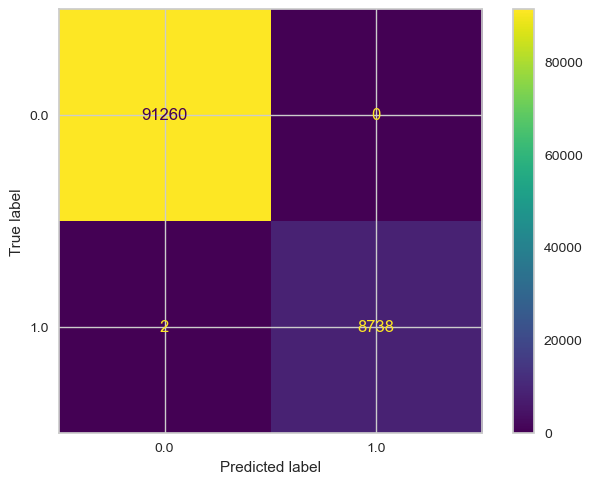

In [159]:
# Performance - Random Forest Classifier with "No class weight"

y_pred_rf_oversample = mdl_rf_oversample.predict(X_test)
print(f"Precision of RF (oversample) validated w/ test set::{metrics.precision_score(Y_test, y_pred_rf_oversample)}")
print(f"Recall of RF (oversample) validated w/ test set::{metrics.recall_score(Y_test, y_pred_rf_oversample)}")
print(f"F1 of RF (oversample) validated w/ test set::{metrics.f1_score(Y_test, y_pred_rf_oversample)}")

cm=metrics.confusion_matrix(Y_test, y_pred_rf_oversample)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_rf_oversample.classes_)
disp.plot()
plt.show()

In [132]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Random Forest Classifier with "adj class weight"

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

mdl_rf_oversample_adj_weight = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=adj_class_weight,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)
mdl_rf_oversample_adj_weight.fit(X_oversampled, Y_oversampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.087403, 1: 0.912597},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)

Precision of RF (oversample + adj class weight) validated w/ test set::0.9998855704313995
Recall of RF (oversample + adj class weight) validated w/ test set::0.9997711670480549
F1 of RF (oversample + adj class weight) validated w/ test set::0.9998283654671319


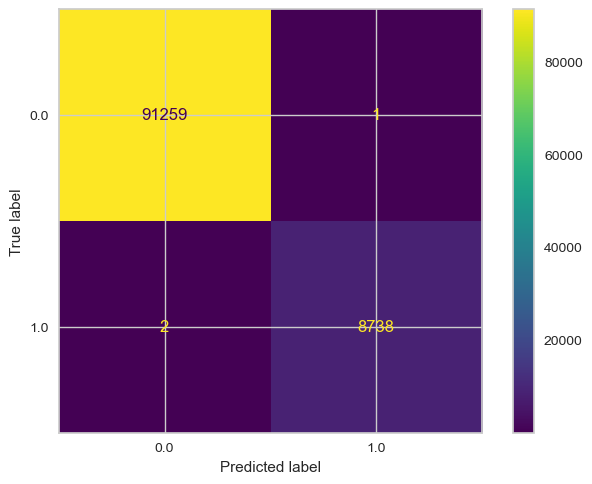

In [162]:
# Performance - Random Forest Classifier with "adj class weight"

y_pred_rf_oversample_adj_weight = mdl_rf_oversample_adj_weight.predict(X_test)
print(f"Precision of RF (oversample + adj class weight) validated w/ test set::{metrics.precision_score(Y_test, y_pred_rf_oversample_adj_weight)}")
print(f"Recall of RF (oversample + adj class weight) validated w/ test set::{metrics.recall_score(Y_test, y_pred_rf_oversample_adj_weight)}")
print(f"F1 of RF (oversample + adj class weight) validated w/ test set::{metrics.f1_score(Y_test, y_pred_rf_oversample_adj_weight)}")

cm=metrics.confusion_matrix(Y_test, y_pred_rf_oversample_adj_weight)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_rf_oversample_adj_weight.classes_)
disp.plot()
plt.show()

In [140]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (heavier class weight) + Oversampling (SMOTE) 
# adj_class_weight02
# Force minority (fraudulent) weight to be 10* more and majority (non-fraudulent) weight to be 10/ less
adj_class_weight02 = {0 : nonfraud_weight / 100, 1: fraud_weight * 100}
# adj_class_weight02 = {0 : fraud_weight * 100, 1: nonfraud_weight / 100}

mdl_rf_oversample_adj_weight02 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=adj_class_weight02,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)
mdl_rf_oversample_adj_weight02.fit(X_oversampled, Y_oversampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.0008740299999999999, 1: 91.2597},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=202406, verbose=0,
                       warm_start=False)

Precision of RF (oversample + adj class weight02) validated w/ test set::0.9998855442371524
Recall of RF (oversample + adj class weight02) validated w/ test set::0.9995423340961098
F1 of RF (oversample + adj class weight02) validated w/ test set::0.9997139097099045


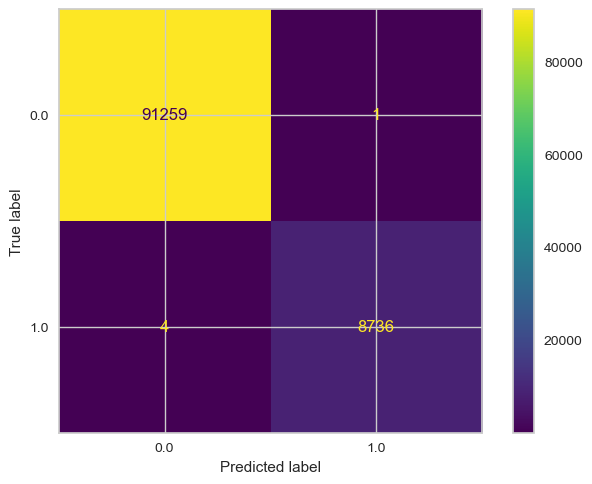

In [163]:
# Performance - Random Forest Classifier with "adj class weight02"

y_pred_rf_oversample_adj_weight02 = mdl_rf_oversample_adj_weight02.predict(X_test)
print(f"Precision of RF (oversample + adj class weight02) validated w/ test set::{metrics.precision_score(Y_test, y_pred_rf_oversample_adj_weight02)}")
print(f"Recall of RF (oversample + adj class weight02) validated w/ test set::{metrics.recall_score(Y_test, y_pred_rf_oversample_adj_weight02)}")
print(f"F1 of RF (oversample + adj class weight02) validated w/ test set::{metrics.f1_score(Y_test, y_pred_rf_oversample_adj_weight02)}")

cm=metrics.confusion_matrix(Y_test, y_pred_rf_oversample_adj_weight02)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_rf_oversample_adj_weight02.classes_)
disp.plot()
plt.show()

In [142]:
mdl_rf_oversample_feature_importance = pd.Series(mdl_rf_oversample.feature_importances_, index=X_test.columns)
print(mdl_rf_oversample_feature_importance)

distance_from_home                0.190038
distance_from_last_transaction    0.073762
ratio_to_median_purchase_price    0.555384
repeat_retailer                   0.009286
used_chip                         0.023101
used_pin_number                   0.033283
online_order                      0.115146
dtype: float64


## Random Forest (RF) Classifier Observation
4 different combination of Feature Engineering (log() + sqrt()), Hyperparameter Tuning (class weight), and Oversampling (SMOTE) techniques.

It turns out in this situation, oversampling w/ SMOTE helps RF to achieve a very good performance already.  Also, it turns out, for this situation, the feature engineering with various scaling mechanism and hyperparameter tunning with different class weight were hurting the model performance (based on performance measured w/ test set).

Furthermore, the model feature_importances also confirms the 3 main features that we observed in previous EDA (ratio_to_median_purchase_price, distance_from_home, and online_order)

So, mdl_rf_oversample, will be the model choice with a F1 score of 0.9998855704313995 (slightly better than other model attempts using Random Forest Classifier), and it yields 1 less false negative with the test set which is crucial to fraud detection.

## Model - Decision Tree Classifier

In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [150]:
# Model - Feature Engineering (scaling w/ log()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Decision Tree Classifier with "No class weight" (Oversample + scaling w/ log())


mdl_dt_oversample_log = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=None, 
    criterion="gini", 
    max_depth=None, 
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=random_seed,
    splitter='best')
mdl_dt_oversample_log.fit(X_oversampled_scaled_log, Y_oversampled_scaled_log)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=202406,
                       splitter='best')

Precision of DT (oversample + log) validated w/ test set::0.15072698735749152
Recall of DT (oversample + log) validated w/ test set::0.9998855835240275
F1 of DT (oversample + log) validated w/ test set::0.2619643579789865


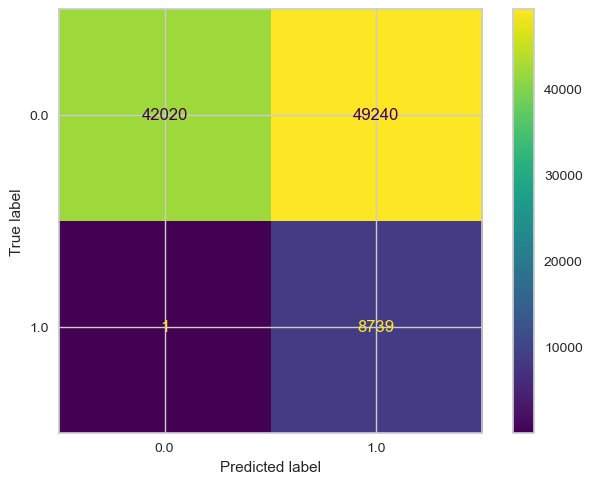

In [155]:
# Performance - Decision Tree Classifier with "No class weight" (Oversample + scaling w/ log())

y_pred_dt_oversample_log = mdl_dt_oversample_log.predict(X_test)
print(f"Precision of DT (oversample + log) validated w/ test set::{metrics.precision_score(Y_test, y_pred_dt_oversample_log)}")
print(f"Recall of DT (oversample + log) validated w/ test set::{metrics.recall_score(Y_test, y_pred_dt_oversample_log)}")
print(f"F1 of DT (oversample + log) validated w/ test set::{metrics.f1_score(Y_test, y_pred_dt_oversample_log)}")

cm=metrics.confusion_matrix(Y_test, y_pred_dt_oversample_log)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_dt_oversample_log.classes_)
disp.plot()
plt.show()

In [154]:
# Model - Feature Engineering (scaling w/ sqrt()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Decision Tree Classifier with "No class weight" (Oversample + scaling w/ sqrt())

mdl_dt_oversample_sqrt = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=None, 
    criterion="gini", 
    max_depth=None, 
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=random_seed,
    splitter='best')
mdl_dt_oversample_sqrt.fit(X_oversampled_scaled_sqrt, Y_oversampled_scaled_sqrt)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=202406,
                       splitter='best')

Precision of DT (oversample + sqrt) validated w/ test set::0.21669270252175854
Recall of DT (oversample + sqrt) validated w/ test set::0.9998855835240275
F1 of DT (oversample + sqrt) validated w/ test set::0.35619230063787727


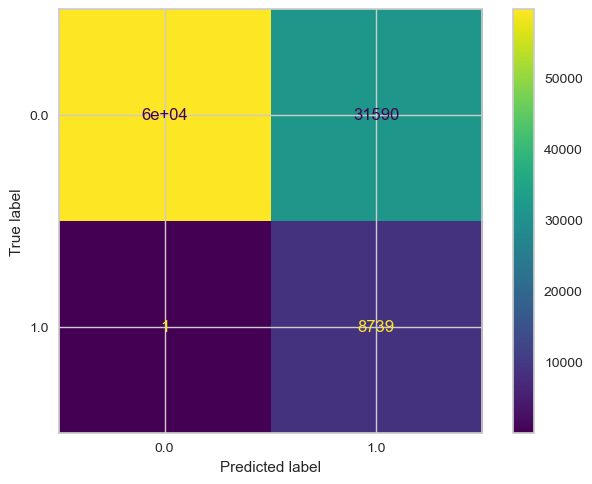

In [156]:
# Performance - Decision Tree Classifier with "No class weight" (Oversample + scaling w/ sqrt())

y_pred_dt_oversample_sqrt = mdl_dt_oversample_sqrt.predict(X_test)
print(f"Precision of DT (oversample + sqrt) validated w/ test set::{metrics.precision_score(Y_test, y_pred_dt_oversample_sqrt)}")
print(f"Recall of DT (oversample + sqrt) validated w/ test set::{metrics.recall_score(Y_test, y_pred_dt_oversample_sqrt)}")
print(f"F1 of DT (oversample + sqrt) validated w/ test set::{metrics.f1_score(Y_test, y_pred_dt_oversample_sqrt)}")

cm=metrics.confusion_matrix(Y_test, y_pred_dt_oversample_sqrt)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_dt_oversample_sqrt.classes_)
disp.plot()
plt.show()

In [146]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Decision Tree Classifier with "No class weight"

mdl_dt_oversample = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=None, 
    criterion="gini", 
    max_depth=None, 
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=random_seed,
    splitter='best')

mdl_dt_oversample.fit(X_oversampled, Y_oversampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=202406,
                       splitter='best')

Precision of DT (oversample) validated w/ test set::0.9994281793229643
Recall of DT (oversample) validated w/ test set::0.9998855835240275
F1 of DT (oversample) validated w/ test set::0.9996568291008923


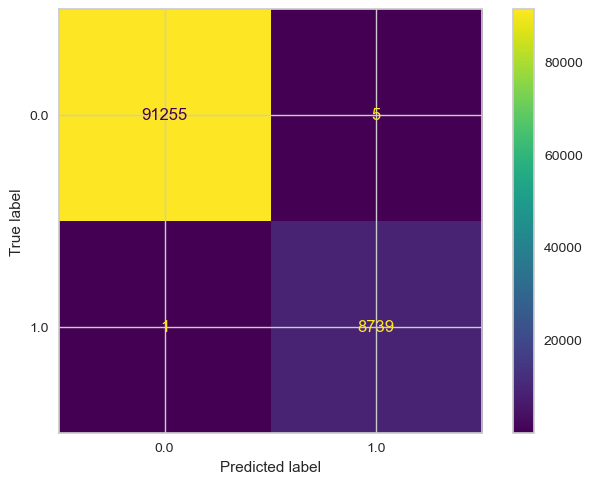

In [160]:
# Performance - Decision Tree Classifier with "No class weight"

y_pred_dt_oversample = mdl_dt_oversample.predict(X_test)
print(f"Precision of DT (oversample) validated w/ test set::{metrics.precision_score(Y_test, y_pred_dt_oversample)}")
print(f"Recall of DT (oversample) validated w/ test set::{metrics.recall_score(Y_test, y_pred_dt_oversample)}")
print(f"F1 of DT (oversample) validated w/ test set::{metrics.f1_score(Y_test, y_pred_dt_oversample)}")

cm=metrics.confusion_matrix(Y_test, y_pred_dt_oversample)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_dt_oversample.classes_)
disp.plot()
plt.show()

In [161]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Decision Tree Classifier with "adj class weight"

mdl_dt_oversample_adj_weight = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=adj_class_weight, 
    criterion="gini", 
    max_depth=None, 
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=random_seed,
    splitter='best')

mdl_dt_oversample_adj_weight.fit(X_oversampled, Y_oversampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.087403, 1: 0.912597},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, monotonic_cst=None,
                       random_state=202406, splitter='best')

Precision of DT (oversample + adj class weight) validated w/ test set::0.9996568291008923
Recall of DT (oversample + adj class weight) validated w/ test set::0.9998855835240275
F1 of DT (oversample + adj class weight) validated w/ test set::0.9997711932273196


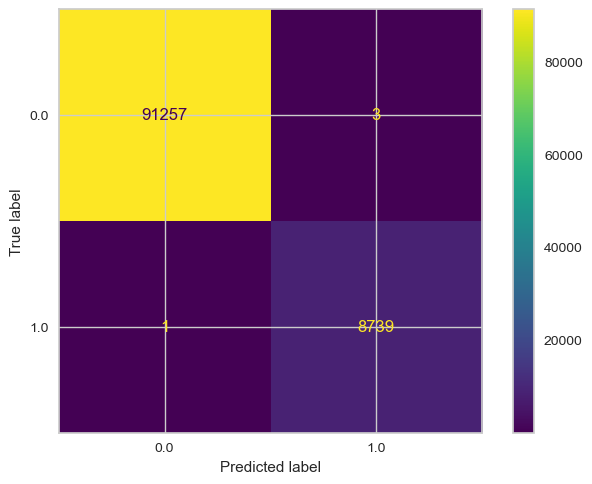

In [165]:
# Performance - Decision Tree Classifier with "adj class weight"

y_pred_dt_oversample_adj_weight = mdl_dt_oversample_adj_weight.predict(X_test)
print(f"Precision of DT (oversample + adj class weight) validated w/ test set::{metrics.precision_score(Y_test, y_pred_dt_oversample_adj_weight)}")
print(f"Recall of DT (oversample + adj class weight) validated w/ test set::{metrics.recall_score(Y_test, y_pred_dt_oversample_adj_weight)}")
print(f"F1 of DT (oversample + adj class weight) validated w/ test set::{metrics.f1_score(Y_test, y_pred_dt_oversample_adj_weight)}")

cm=metrics.confusion_matrix(Y_test, y_pred_dt_oversample_adj_weight)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_dt_oversample_adj_weight.classes_)
disp.plot()
plt.show()

In [166]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# Decision Tree Classifier with "adj class weight02"

mdl_dt_oversample_adj_weight02 = DecisionTreeClassifier(
    ccp_alpha=0.0, 
    class_weight=adj_class_weight02, 
    criterion="gini", 
    max_depth=None, 
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    random_state=random_seed,
    splitter='best')

mdl_dt_oversample_adj_weight02.fit(X_oversampled, Y_oversampled)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 0.0008740299999999999, 1: 91.2597},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, monotonic_cst=None,
                       random_state=202406, splitter='best')

Precision of DT (oversample + adj class weight02) validated w/ test set::0.9994281139197072
Recall of DT (oversample + adj class weight02) validated w/ test set::0.9997711670480549
F1 of DT (oversample + adj class weight02) validated w/ test set::0.999599611050735


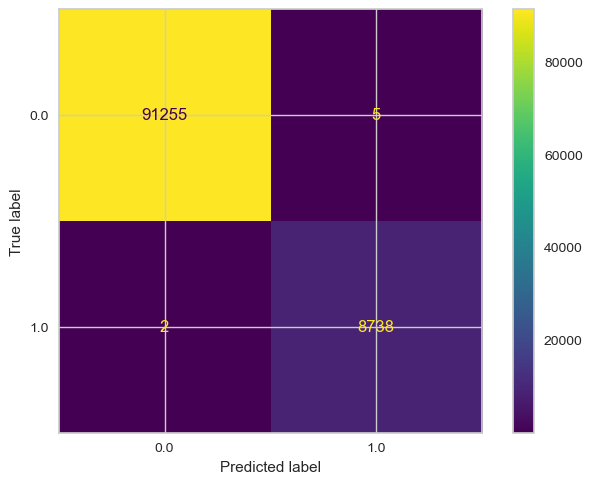

In [167]:
# Performance - Decision Tree Classifier with "adj class weight02"

y_pred_dt_oversample_adj_weight02 = mdl_dt_oversample_adj_weight02.predict(X_test)
print(f"Precision of DT (oversample + adj class weight02) validated w/ test set::{metrics.precision_score(Y_test, y_pred_dt_oversample_adj_weight02)}")
print(f"Recall of DT (oversample + adj class weight02) validated w/ test set::{metrics.recall_score(Y_test, y_pred_dt_oversample_adj_weight02)}")
print(f"F1 of DT (oversample + adj class weight02) validated w/ test set::{metrics.f1_score(Y_test, y_pred_dt_oversample_adj_weight02)}")

cm=metrics.confusion_matrix(Y_test, y_pred_dt_oversample_adj_weight02)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_dt_oversample_adj_weight02.classes_)
disp.plot()
plt.show()

In [168]:
mdl_dt_oversample_adj_weight_feature_importance = pd.Series(mdl_dt_oversample_adj_weight.feature_importances_, index=X_test.columns)
print(mdl_dt_oversample_adj_weight_feature_importance)

distance_from_home                0.351891
distance_from_last_transaction    0.441809
ratio_to_median_purchase_price    0.178621
repeat_retailer                   0.001737
used_chip                         0.005650
used_pin_number                   0.006482
online_order                      0.013811
dtype: float64


## Decision Tree (DT) Classifier Observation
4 different combination of Feature Engineering (log() + sqrt()), Hyperparameter Tuning (class weight), and Oversampling (SMOTE) techniques.

It turns out in this situation, oversampling w/ SMOTE + class weight helps DT to achieve a very good performance.  Again, it turns out, for this situation, the feature engineering with various scaling mechanism were hurting the model performance (based on performance measured w/ test set).  However, hyperparameter tunning with class weight helps DT to achieve the best performance (again, with the least false positive rate)

Furthermore, the model feature_importances with feature spliting is putting more importance to the distance related features (instead of ratio_to_median_purchase_price) 

So, mdl_dt_oversample_adj_weight, will be the model choice with a F1 score of 0.9997711932273196 (slightly better than other model attempts using DT Classifier but without hyperparameter tunning), and it yields 1 less false negative with the test set which is crucial to fraud detection.

## Model - K-Neighbors Classifier

In [177]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [178]:
# Model - Feature Engineering (scaling w/ log()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# K-Neighbors Classifier with "No class weight" (Oversample + scaling w/ log())


mdl_knn_oversample_log = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform')
mdl_knn_oversample_log.fit(X_oversampled_scaled_log, Y_oversampled_scaled_log)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Precision of KNN (oversample + log) validated w/ test set::0.11066482743697933
Recall of KNN (oversample + log) validated w/ test set::0.9362700228832952
F1 of KNN (oversample + log) validated w/ test set::0.19793430409752794


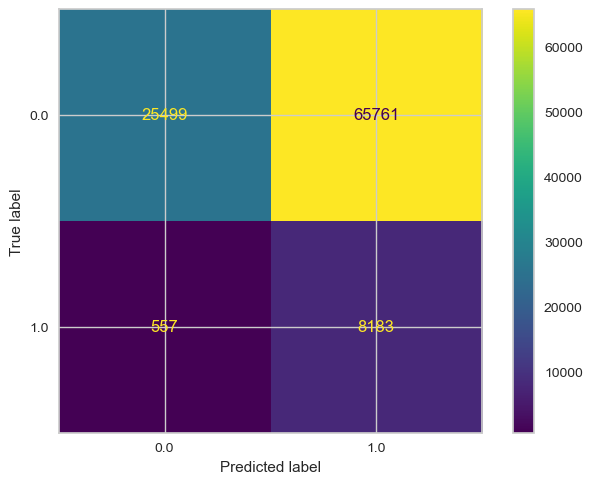

In [181]:
# Performance - K-Neighbors Classifier with "No class weight" (Oversample + scaling w/ log())

y_pred_knn_oversample_log = mdl_knn_oversample_log.predict(X_test)
print(f"Precision of KNN (oversample + log) validated w/ test set::{metrics.precision_score(Y_test, y_pred_knn_oversample_log)}")
print(f"Recall of KNN (oversample + log) validated w/ test set::{metrics.recall_score(Y_test, y_pred_knn_oversample_log)}")
print(f"F1 of KNN (oversample + log) validated w/ test set::{metrics.f1_score(Y_test, y_pred_knn_oversample_log)}")

cm=metrics.confusion_matrix(Y_test, y_pred_knn_oversample_log)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_knn_oversample_log.classes_)
disp.plot()
plt.show()

In [180]:
# Model - Feature Engineering (scaling w/ sqrt()) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# K-Neighbors Classifier with "No class weight" (Oversample + scaling w/ sqrt())


mdl_knn_oversample_sqrt = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform')
mdl_knn_oversample_sqrt.fit(X_oversampled_scaled_sqrt, Y_oversampled_scaled_sqrt)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Precision of KNN (oversample + sqrt) validated w/ test set::0.17174544606315076
Recall of KNN (oversample + sqrt) validated w/ test set::0.9266590389016018
F1 of KNN (oversample + sqrt) validated w/ test set::0.28978299372059324


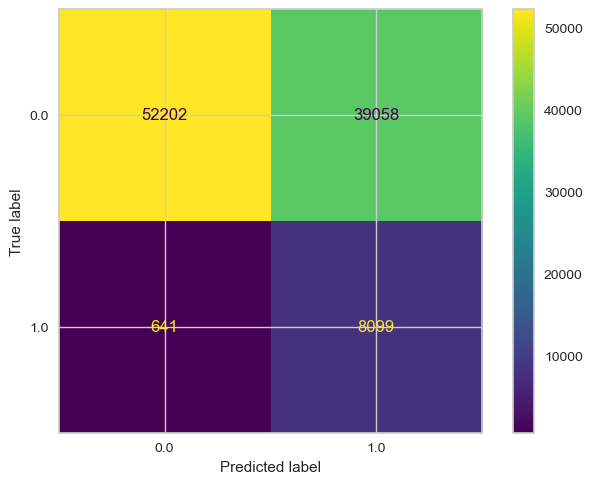

In [183]:
# Performance - K-Neighbors Classifier with "No class weight" (Oversample + scaling w/ sqrt())

y_pred_knn_oversample_sqrt = mdl_knn_oversample_sqrt.predict(X_test)
print(f"Precision of KNN (oversample + sqrt) validated w/ test set::{metrics.precision_score(Y_test, y_pred_knn_oversample_sqrt)}")
print(f"Recall of KNN (oversample + sqrt) validated w/ test set::{metrics.recall_score(Y_test, y_pred_knn_oversample_sqrt)}")
print(f"F1 of KNN (oversample + sqrt) validated w/ test set::{metrics.f1_score(Y_test, y_pred_knn_oversample_sqrt)}")

cm=metrics.confusion_matrix(Y_test, y_pred_knn_oversample_sqrt)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_knn_oversample_sqrt.classes_)
disp.plot()
plt.show()

In [186]:
# Model - Feature Engineering (no scaling) + Hyperparameter Tuning (class weight) + Oversampling (SMOTE) 
# K-Neighbors Classifier with "No class weight" (Oversample)


mdl_knn_oversampled = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='uniform')
mdl_knn_oversampled.fit(X_oversampled, Y_oversampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

Precision of KNN (oversample) validated w/ test set::0.796221198156682
Recall of KNN (oversample) validated w/ test set::0.9884439359267735
F1 of KNN (oversample) validated w/ test set::0.8819806023481368


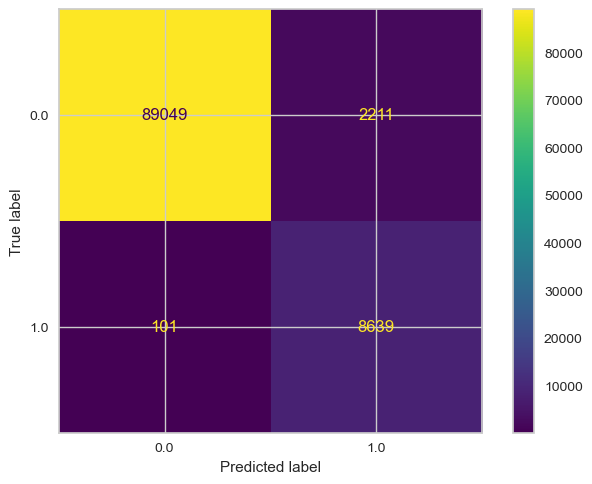

In [188]:
# Performance - K-Neighbors Classifier with "No class weight" (Oversample)

y_pred_knn_oversample = mdl_knn_oversampled.predict(X_test)
print(f"Precision of KNN (oversample) validated w/ test set::{metrics.precision_score(Y_test, y_pred_knn_oversample)}")
print(f"Recall of KNN (oversample) validated w/ test set::{metrics.recall_score(Y_test, y_pred_knn_oversample)}")
print(f"F1 of KNN (oversample) validated w/ test set::{metrics.f1_score(Y_test, y_pred_knn_oversample)}")

cm=metrics.confusion_matrix(Y_test, y_pred_knn_oversample)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_knn_oversampled.classes_)
disp.plot()
plt.show()

In [189]:
# K-Neighbors Classifier with "No class weight" (Oversample + weights=distance)


mdl_knn_oversampled_distance = KNeighborsClassifier(
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    metric_params=None,
    n_jobs=-1,
    n_neighbors=5,
    p=2,
    weights='distance')
mdl_knn_oversampled_distance.fit(X_oversampled, Y_oversampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')

Precision of KNN (oversample + weights=distance) validated w/ test set::0.8095684803001876
Recall of KNN (oversample + weights=distance) validated w/ test set::0.9874141876430206
F1 of KNN (oversample + weights=distance) validated w/ test set::0.8896907216494845


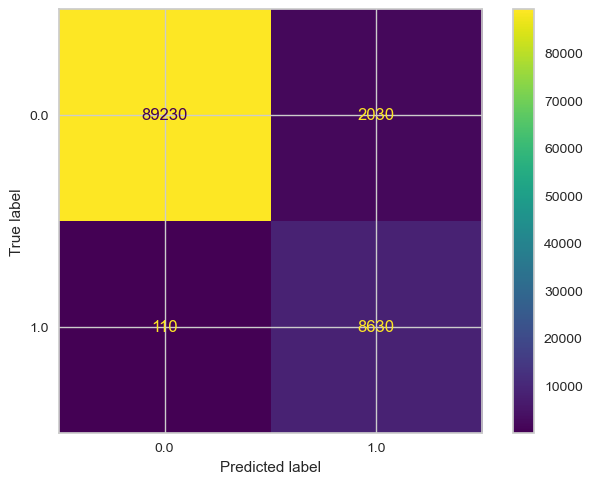

In [190]:
# Performance - K-Neighbors Classifier with "No class weight" (Oversample + weights=distance)

y_pred_knn_oversample_distance = mdl_knn_oversampled_distance.predict(X_test)
print(f"Precision of KNN (oversample + weights=distance) validated w/ test set::{metrics.precision_score(Y_test, y_pred_knn_oversample_distance)}")
print(f"Recall of KNN (oversample + weights=distance) validated w/ test set::{metrics.recall_score(Y_test, y_pred_knn_oversample_distance)}")
print(f"F1 of KNN (oversample + weights=distance) validated w/ test set::{metrics.f1_score(Y_test, y_pred_knn_oversample_distance)}")

cm=metrics.confusion_matrix(Y_test, y_pred_knn_oversample_distance)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl_knn_oversampled_distance.classes_)
disp.plot()
plt.show()

## Conclusion of the exercise
From a business perspective:
1. Credit card fraud is still very much relevant even with other payment method like Zelle, or Vemo
2. Current dataset is relatively simple and additional features could be collected (but additional cost to collect) and may improve the model performance even further (e.g. location like GPS of the transaction or the type of permise where the transaction takes place, as many times, fraudsters test the validity of a stolen card at a gas station, or a automated kiosk)

From a technical perspective:
1. Data cleaning, EDA & hyperparameter tunning techniques and understanding are still necessary to be practiced to gain "muscle memory" (even with low-code framework like PyCaret which provides sense of direction and raw guess of hyperparameter "starters").  
1a. As comparison between RF & DT shows, 1 model works better with just oversampling, but the other model works better with class weight, one of the hyperparameters.  They perform similarly well, but require slight different tweak
1b. As the KNN model attempt shows, it isn't a great model for this situation
1c. F1, & precision + recall are the more desired metrics to measure performance as we want to minimize false negative, ie, loss

2. Over sampling technique w/ SMOTE has already been implemented but requires attention to the details (SMOTE vs. SMOTENC)
2a. We need SMOTENC since we have both numerical and categorical.  If we are not careful and use regular SMOTE, then it will ingect 0.3, 0.6 types of values to the dataset and they won't make sense in this situation

3. Tried to maintain the proportions of all the categorical features (including the "fraud" label) and got error since the technique can't find a split that will satisfy all the requirements
3a. A new feature, called "card_present", was generated by combining the 2 categorical features "" & "" as they indicate whether the transaction is a "card_present" transaction, ie, the card holder is there at the point-of-sales to present the card or enter the PIN

4. Un-expected negative effect to model performance on feature scaling using log() & sqrt() which are common treatment for skewed features

5. Correlation matric wasn't a great help since the continuous numerical features are not correlated and the others are categorical features

6. Pairplot, on the other hand, was a great help since we can quickly visualize the fraud / non-fraud occurences w/ the color dots

7. Model needs to be retrained every so often; therefore, to make the operation scalerable, it is best to operationalize workflow pipeline (similar to PyCaret) so we can quickly determine if re-training is needed (due to fraudsters changing their tactics)

In [192]:
#github URL

https://github.com/project4sharing/exp_credit_card_fraud/blob/main/credit_card_fraud-20240625-final.ipynb